In [1]:
%load_ext autoreload
%autoreload 2

# Import packages

In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as shc 
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture



warnings.filterwarnings('ignore')

# Loading the data

In [3]:
load_dotenv()

True

In [4]:
data_get_env =os.getenv("DATA_HR")

In [5]:
# Set the working directory
os.chdir('/Users/felixhaberl/code/Emroullier/hr-data-analytics')

In [6]:
print(os.getcwd())

/Users/felixhaberl/code/emroullier/hr-data-analytics


In [7]:
data = pd.read_csv(data_get_env)

In [8]:
data.head(5)

ID      Name       Department     GEO             Role  Rising_Star  \
0   1    BRADDY       Operations      US               VP          NaN   
1   2     BORST            Sales      UK  Senior Director          NaN   
2   3  BIRDWELL          Finance  France  Senior Director          NaN   
3   4      BENT  Human Resources   China  Senior Director          NaN   
4   5     BAZAN               IT   Korea         Director          NaN   

   Will_Relocate  Critical  Trending Perf  Talent_Level  ...  \
0              0       1.0              3             6  ...   
1              0       NaN              3             6  ...   
2              0       NaN              3             6  ...   
3              0       NaN              3             6  ...   
4              0       NaN              3             6  ...   

   Emp_Competitive_4  Emp_Competitive_5  Emp_Collaborative_1  \
0                  2                  2                    2   
1                  4                  1                    3   
2                  2                  5                    2   
3                  5                  1                    1   
4                  5                  3                    5   

   Emp_Collaborative_2  Emp_Collaborative_3  Emp_Collaborative_4  \
0                    2                    2                    1   
1                    2                    5                    1   
2                    2                    4                    4   
3                    2                    4                    4   
4                    1                    2                    5   

   Emp_Collaborative_5  Sensor_StepCount  Sensor_Heartbeat(Average/Min)  \
0                    5              1841                             61   
1                    5              1990                             90   
2                    4              3193                             80   
3                    1              3248                             77   
4                    4              3149                             80   

   Sensor_Proximity(1-highest/10-lowest)  
0                                      9  
1                                      8  
2                                      8  
3                                      6  
4                                     10  

[5 rows x 62 columns]

# Data Preparation

In [9]:
data.drop(columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales'], inplace = True)

data = data.rename(columns={
    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
})

In [10]:
# Convert column names to lower snake case
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')

In [11]:
# combine all the men_leave and the women_leave column

data['leave'] = data['women_leave'].fillna(data['men_leave'])
data['leave'] = data['leave'].fillna(0)
data.drop(columns = ['women_leave', 'men_leave'], inplace = True)


# General Prerequisites

In [12]:
# checking missing values

data.isnull().sum().sort_values(ascending=False)


critical                 14519
emp_sat_onprem_4           128
emp_sat_onprem_5           128
department                   0
emp_competitive_5            0
emp_identity                 0
emp_role                     0
emp_position                 0
emp_title                    0
emp_competitive_1            0
emp_competitive_2            0
emp_competitive_3            0
emp_competitive_4            0
emp_collaborative_2          0
emp_collaborative_1          0
emp_work_status_4            0
emp_collaborative_3          0
emp_collaborative_4          0
emp_collaborative_5          0
sensor_stepcount             0
sensor_heartbeat             0
sensor_proximity             0
emp_work_status_5            0
emp_work_status2             0
emp_work_status_3            0
number_project               0
role                         0
will_relocate                0
percent_remote               0
emp_sat_remote_1             0
emp_sat_remote_2             0
emp_engagement_1             0
last_eva

In [13]:
# impute binary missing values for critical column

data.loc[data['critical'].isna(), 'critical'] = 0


In [14]:
# covert gender column into binary classification column

data['gender'] = data['gender'].map({'F': 1, 'M': 0})


In [15]:
# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']

imputer = SimpleImputer(strategy='most_frequent')

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])


In [16]:
# target imbalancing
# the target is imbalanced, however this can be sorted using the class_weight='balanced' when using LogisticRegression

data['left_company'].value_counts(normalize = True)


left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

# Numerical Features Data Cleaning ONLY

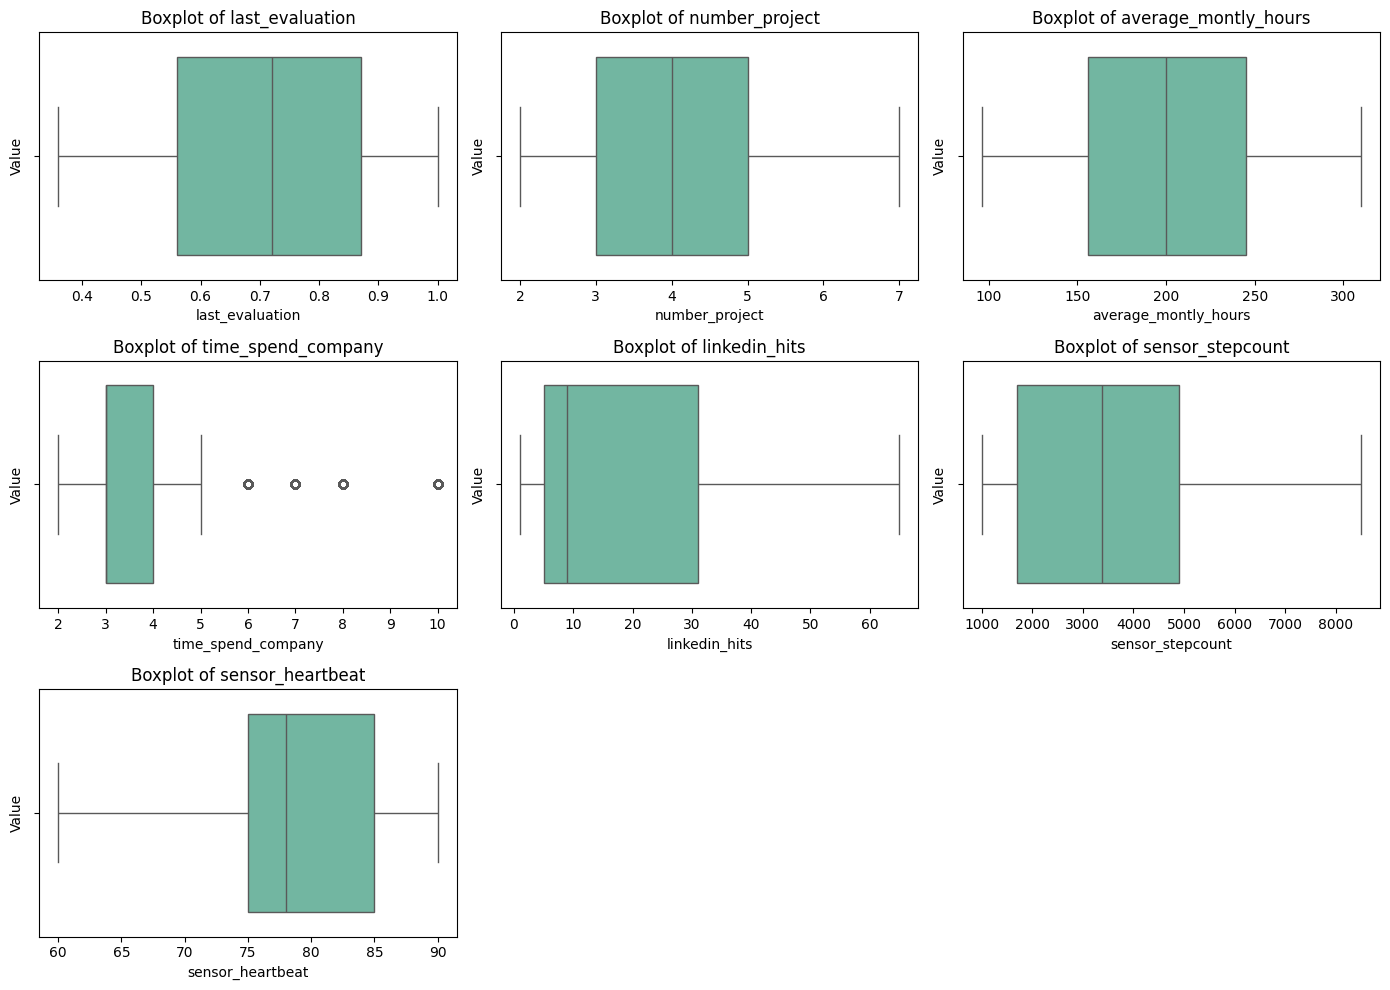

In [17]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [18]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.

rb_scaler = RobustScaler()
data['time_spend_company'] = rb_scaler.fit_transform(data[['time_spend_company']])


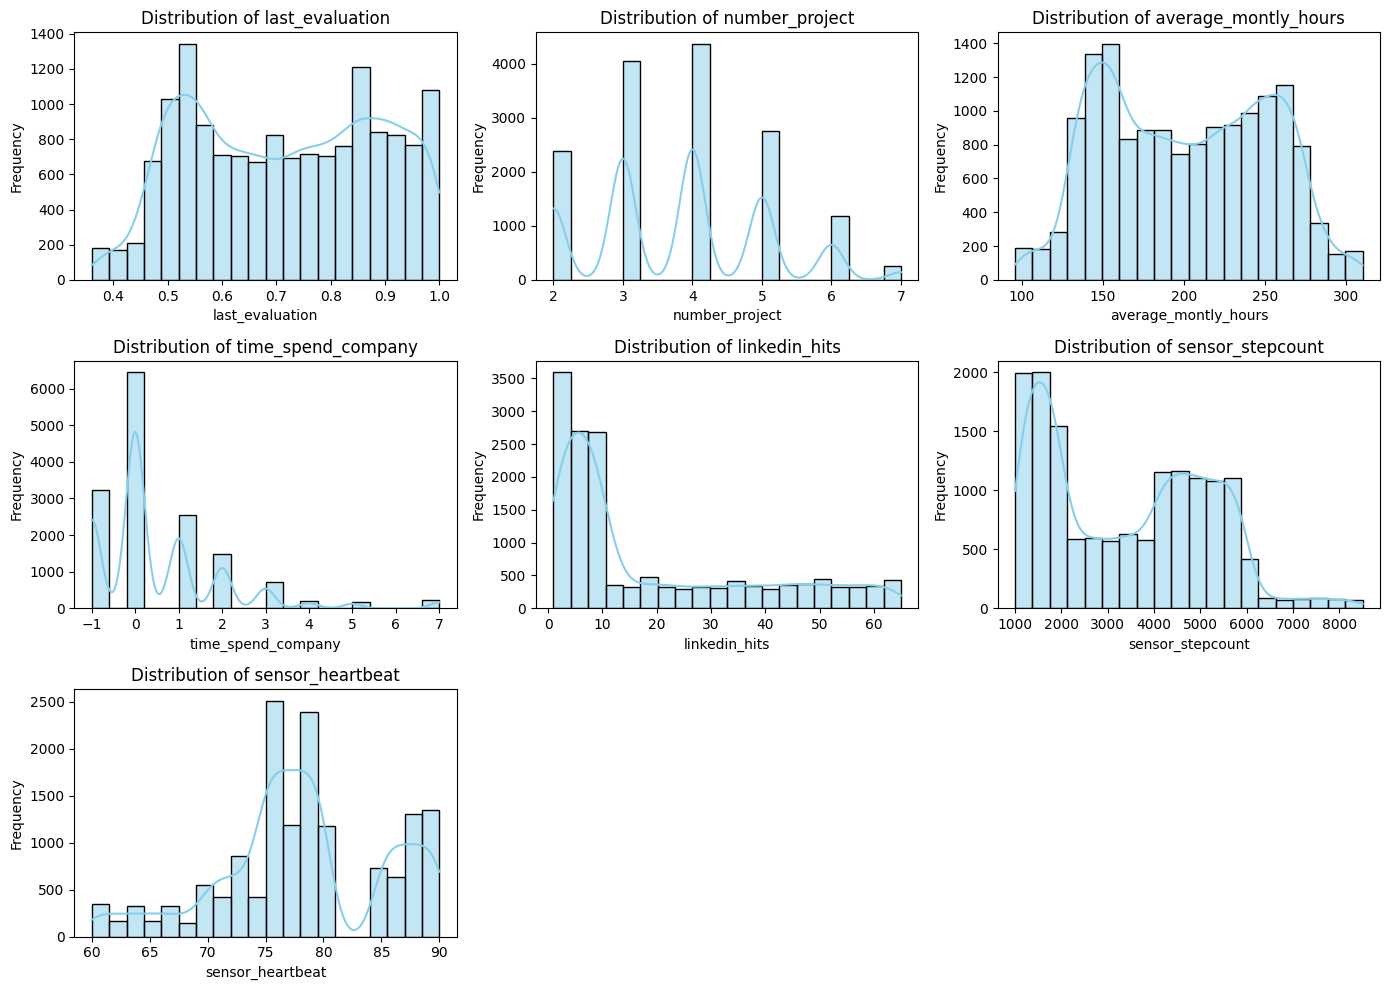

In [19]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [20]:
# for all other numerical variables, use the minmaxscaler

minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
data[minmaxscaler_columns] = scaler.fit_transform(data[minmaxscaler_columns])


# Categorical Features ONLY Feature Engineering

In [21]:
# ordinal encoding for salary

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data[['salary']])
data['encoded_salary'] = ordinal_encoder.transform(data[['salary']]) # 1 = low, 2 = medium, 3 = high
data.drop(columns = ['salary'], inplace = True)


In [22]:
# OneHotEncoding for department, geo and role

ohe_columns = ['department', 'geo', 'role']

ohe = OneHotEncoder(sparse_output = False)

ohe_data = ohe.fit_transform(data[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))

encoded_data = pd.concat([data, ohe_df], axis=1)

encoded_data.drop(columns = ['department', 'geo', 'role'], inplace = True)


# Variable allocation

In [23]:
# define x and y variables

X = encoded_data.drop(columns = 'left_company')

y = encoded_data['left_company']


# Feature correlation

<Axes: >

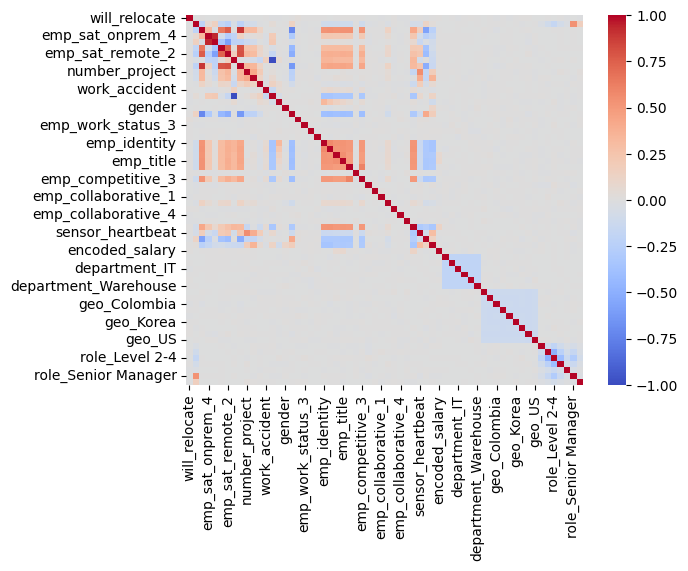

In [24]:
# Correlation Matrix
sns.heatmap(encoded_data.corr(), cmap='coolwarm')


In [25]:
# visualise the correlation

# Calculate the correlation matrix
corr_matrix = encoded_data.corr()

# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation

corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

corr_df.head()


feature_1         feature_2  correlation
180  emp_sat_onprem_5  emp_sat_onprem_4     0.930062
126   last_evaluation    percent_remote     0.897223
352   last_evaluation  emp_sat_remote_2     0.805922
297   last_evaluation  emp_sat_remote_1     0.796292
124  emp_sat_remote_2    percent_remote     0.762327

In [26]:
# remove highly correlated features >= 0.7 or <= -0.7

correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]

X.drop(columns = ['emp_sat_onprem_4', 'percent_remote', 'emp_sat_remote_2', 'emp_sat_remote_1', 'emp_engagement_1','critical','emp_competitive_1','emp_competitive_2','emp_competitive_3','emp_competitive_4','emp_competitive_5','emp_collaborative_1','emp_collaborative_2','emp_collaborative_3','emp_collaborative_4','emp_collaborative_5'], inplace = True)


In [27]:
X.isnull().sum().sort_values(ascending=False)

will_relocate                 0
department_Finance            0
department_IT                 0
department_Operations         0
department_Sales              0
department_Warehouse          0
geo_Australia                 0
geo_China                     0
geo_Colombia                  0
geo_France                    0
geo_Japan                     0
geo_Korea                     0
geo_Turkey                    0
geo_UK                        0
geo_US                        0
role_Director                 0
role_Level 1                  0
role_Level 2-4                0
role_Manager                  0
role_Senior Director          0
role_Senior Manager           0
department_Human Resources    0
encoded_salary                0
emp_sat_onprem_5              0
leave                         0
last_evaluation               0
number_project                0
average_montly_hours          0
time_spend_company            0
work_accident                 0
promotion_last_5years         0
gender  

# Unsupervised Learning

In [28]:
# Create a copy of X to store the clusters and add company left
X_cluster=X
X_cluster['left_company']=data['left_company']

## K-Means (Emily)

### Five clusters

Cluster Centers:
 [[ 5.01081081e-01  1.00000000e+00  4.64265203e-01  3.56756757e-01
   4.73574135e-01  3.29729730e-02  1.67027027e-01  8.10810811e-03
   5.12972973e-01  5.02559122e-01  2.96054054e+00  3.04648649e+00
   2.96864865e+00  2.97675676e+00  1.52054054e+00  1.51405405e+00
   1.50378378e+00  1.48756757e+00  1.83140324e-01  6.42288288e-01
   8.01783784e+00  8.66486486e-01  1.34324324e+00  1.69189189e-01
   1.65405405e-01  1.67027027e-01  1.66486486e-01  1.67567568e-01
   1.64324324e-01  1.05945946e-01  1.10270270e-01  1.14594595e-01
   1.10810811e-01  1.03783784e-01  1.16756757e-01  1.09189189e-01
   1.28648649e-01  1.00000000e-01  4.43243243e-02  2.22702703e-01
   4.59459459e-01  1.57297297e-01  2.27027027e-02  8.59459459e-02
   7.56756757e-03  2.43243243e-02]
 [ 4.88274203e-01  4.02164762e+00  6.52341401e-01  4.90920024e-01
   5.94770177e-01  3.15213470e+00  1.24473842e-01  3.00661455e-02
   5.22549609e-01  2.05943701e-01  3.03968731e+00  3.00601323e+00
   3.03668070e+00  3.13

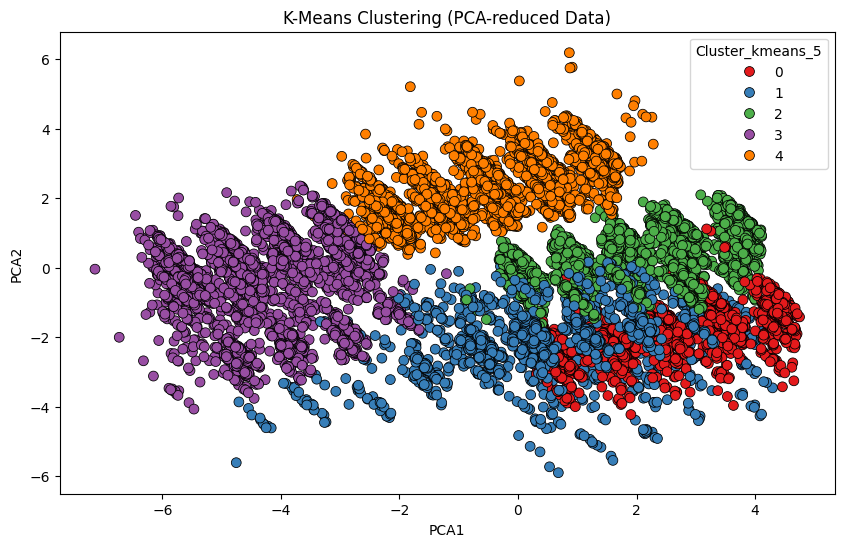

In [29]:
kmeans_5 = KMeans(n_clusters=5, random_state=42)
data['Cluster_kmeans_5'] = kmeans_5.fit_predict(X)
X_cluster['Cluster_kmeans_5']=data['Cluster_kmeans_5']
# Print cluster centers
print("Cluster Centers:\n", kmeans_5.cluster_centers_)

# Add the cluster labels to the original data
data['Cluster_kmeans_5'] = kmeans_5.labels_
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster_kmeans_5'] = data['Cluster_kmeans_5']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_5', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_5')
plt.show()


In [30]:
X_cluster.groupby('Cluster_kmeans_5').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_kmeans_5                                                     
0                      0.501081          1.000000         0.464265   
1                      0.488288          4.022222         0.652309   
2                      0.498747          4.902486         0.306113   
3                      0.503256          4.000000         0.778974   
4                      0.503600          3.997257         0.747616   

                  number_project  average_montly_hours  time_spend_company  \
Cluster_kmeans_5                                                             
0                       0.356757              0.473574            0.032973   
1                       0.491051              0.594850            3.150751   
2                       0.276084              0.419922            0.093852   
3                       0.426643              0.550009            0.498816   
4                       0.362496              0.500311           -0.002057   

                  work_accident  promotion_last_5years    gender  \
Cluster_kmeans_5                                                   
0                      0.167027               0.008108  0.512973   
1                      0.124324               0.030030  0.522523   
2                      0.122760               0.002313  0.511467   
3                      0.145648               0.019834  0.505921   
4                      0.179637               0.059993  0.484745   

                  linkedin_hits  ...    geo_UK    geo_US  role_Director  \
Cluster_kmeans_5                 ...                                      
0                      0.502559  ...  0.128649  0.100000       0.044324   
1                      0.205931  ...  0.117117  0.108108       0.048649   
2                      0.454847  ...  0.113124  0.113509       0.044325   
3                      0.070590  ...  0.121374  0.101835       0.043221   
4                      0.083187  ...  0.117244  0.114501       0.041481   

                  role_Level 1  role_Level 2-4  role_Manager  \
Cluster_kmeans_5                                               
0                     0.222703        0.459459      0.157297   
1                     0.203604        0.472072      0.157958   
2                     0.219696        0.458470      0.162844   
3                     0.224097        0.460036      0.159858   
4                     0.213233        0.452520      0.164895   

                  role_Senior Director  role_Senior Manager   role_VP  \
Cluster_kmeans_5                                                        
0                             0.022703             0.085946  0.007568   
1                             0.017417             0.091892  0.008408   
2                             0.023897             0.083831  0.006938   
3                             0.021906             0.082593  0.008289   
4                             0.020912             0.100788  0.006171   

                  left_company  
Cluster_kmeans_5                
0                     0.024324  
1                     0.471471  
2                     0.387743  
3                     0.212552  
4                     0.003771  

[5 rows x 46 columns]

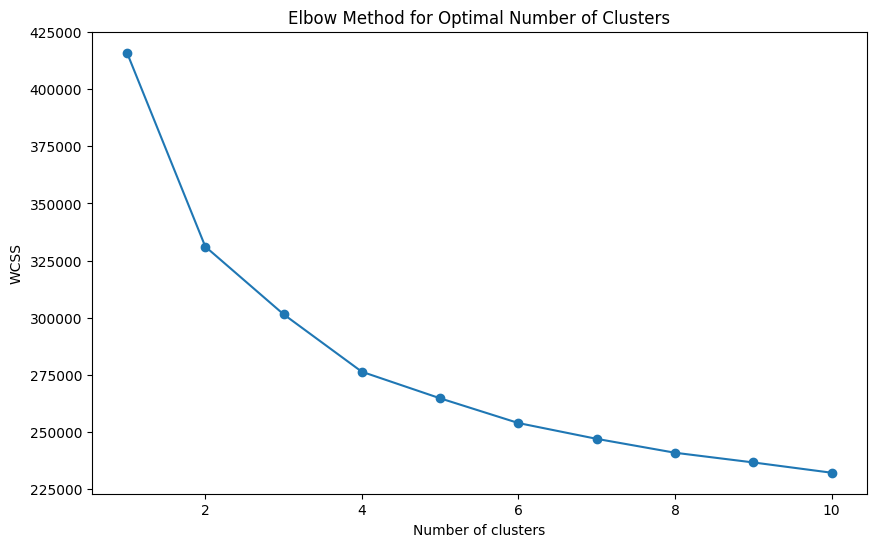

In [31]:
# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [32]:
# # Print cluster centers
# cluster_centers_kmeans_5 = pd.DataFrame(kmeans_5.cluster_centers_, columns=X.columns)
# print("Cluster Centers:\n", cluster_centers_kmeans_5)

In [33]:
# Analyze the number of points in each cluster
cluster_distribution = data['Cluster_kmeans_5'].value_counts().sort_index()
print("Cluster Distribution:\n", cluster_distribution)

Cluster Distribution:
 Cluster_kmeans_5
0    1850
1    1665
2    5189
3    3378
4    2917
Name: count, dtype: int64


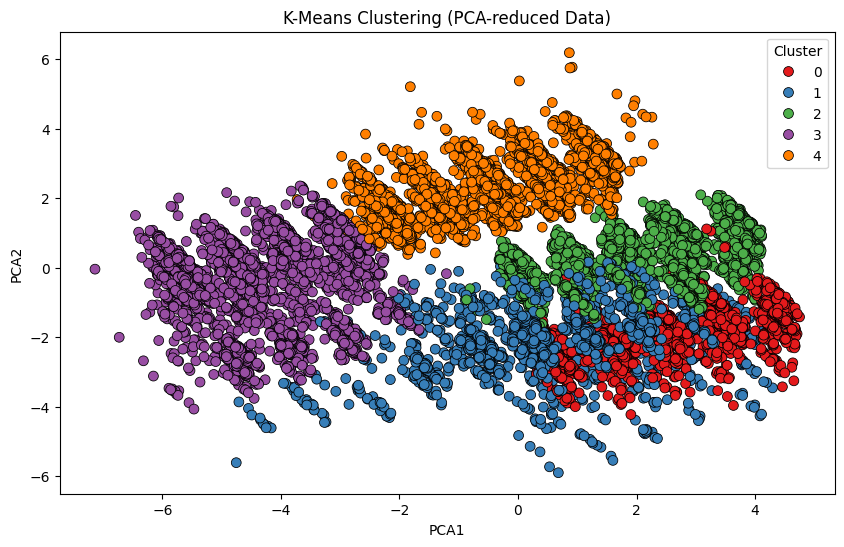

In [34]:
# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster_kmeans_5'] = data['Cluster_kmeans_5']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_5', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

Comparison Table:
 Cluster_kmeans_5         0         1         2         3         4
left_company                                                      
0                 0.157945  0.077004  0.278001  0.232762  0.254288
1                 0.012602  0.219826  0.563428  0.201064  0.003080


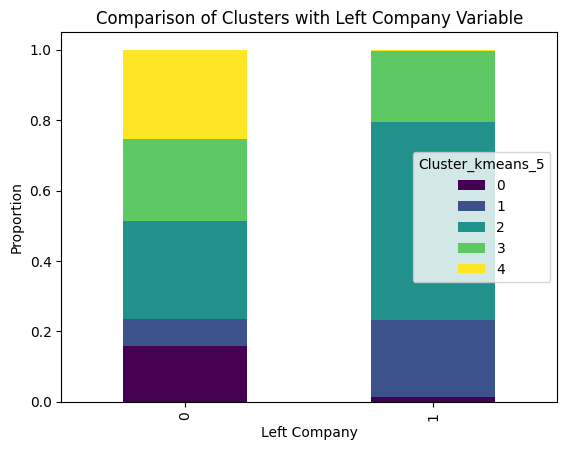

In [35]:
# If you have external variables, compare them with clusters
# For example, comparing clusters with the original 'left_company' variable

comparison_df = data[['left_company', 'Cluster_kmeans_5']]
comparison_table = pd.crosstab(comparison_df['left_company'], comparison_df['Cluster_kmeans_5'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Left Company')
plt.ylabel('Proportion')
plt.legend(title='Cluster_kmeans_5')
plt.show()

### Four clusters

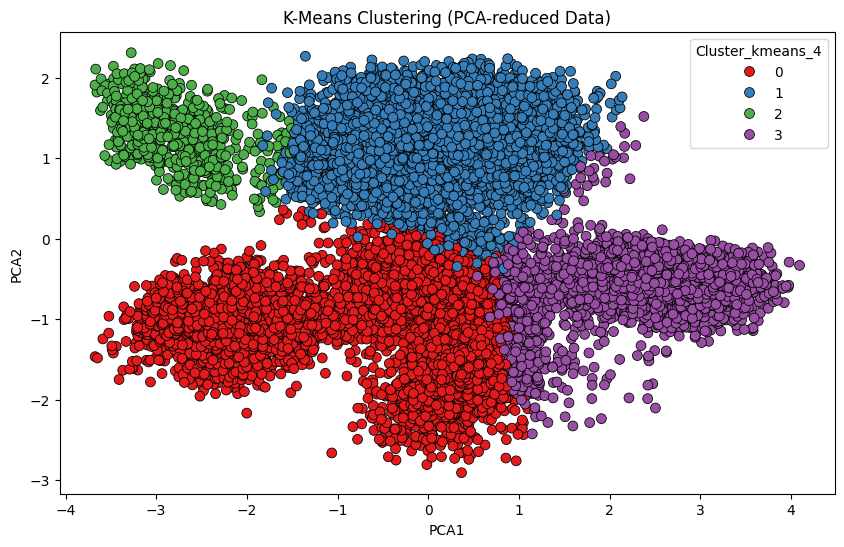

In [36]:
selected_features = ['last_evaluation', 'number_project', 'average_montly_hours', 'sensor_stepcount','sensor_heartbeat'] 
X_selected = data[selected_features]

# Standardize the selected features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_4 = KMeans(n_clusters=4, random_state=42)
data['Cluster_kmeans_4'] = kmeans_4.fit_predict(X_scaled)
X_cluster['Cluster_kmeans_4']=data['Cluster_kmeans_4']

# Visualize the clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster_kmeans_4'] = data['Cluster_kmeans_4']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_4', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_4')
plt.show()

In [37]:

X_cluster.groupby('Cluster_kmeans_4').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_kmeans_4                                                     
0                      0.493872          3.964227         0.308093   
1                      0.503895          3.915796         0.756104   
2                      0.531046          4.879085         0.276961   
3                      0.496546          3.718480         0.757441   

                  number_project  average_montly_hours  time_spend_company  \
Cluster_kmeans_4                                                             
0                       0.269725              0.410065            0.289003   
1                       0.367611              0.507247            0.378750   
2                       0.007190              0.216748            0.058824   
3                       0.672712              0.731438            1.471071   

                  work_accident  promotion_last_5years    gender  \
Cluster_kmeans_4                                                   
0                      0.151540               0.022855  0.508115   
1                      0.175866               0.027847  0.500912   
2                      0.065359               0.006536  0.539216   
3                      0.066062               0.003886  0.507772   

                  linkedin_hits  ...    geo_US  role_Director  role_Level 1  \
Cluster_kmeans_4                 ...                                          
0                      0.492237  ...  0.108811       0.044717      0.218947   
1                      0.084991  ...  0.109564       0.040941      0.217305   
2                      0.460835  ...  0.122549       0.052288      0.228758   
3                      0.149834  ...  0.103195       0.047927      0.214594   

                  role_Level 2-4  role_Manager  role_Senior Director  \
Cluster_kmeans_4                                                       
0                       0.462570      0.157999              0.023683   
1                       0.458810      0.163103              0.021051   
2                       0.444444      0.155229              0.016340   
3                       0.455959      0.167098              0.021589   

                  role_Senior Manager   role_VP  left_company  \
Cluster_kmeans_4                                                
0                            0.084962  0.007122      0.181020   
1                            0.091828  0.006962      0.000663   
2                            0.098039  0.004902      0.879085   
3                            0.083333  0.009499      0.835924   

                  Cluster_kmeans_5  
Cluster_kmeans_4                    
0                         1.477145  
1                         3.235041  
2                         2.191176  
3                         1.756477  

[4 rows x 47 columns]

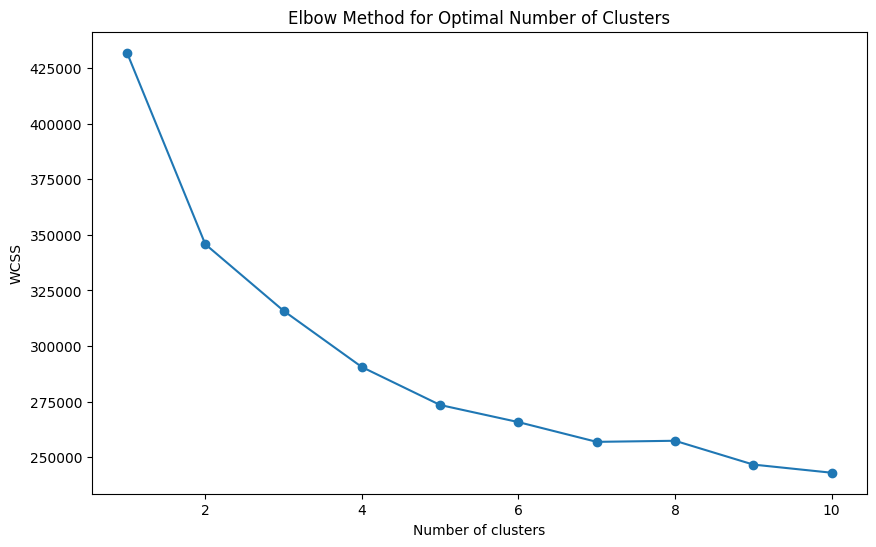

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Comparison Table:
 left_company             0         1
Cluster_kmeans_4                    
0                 0.818980  0.181020
1                 0.999337  0.000663
2                 0.120915  0.879085
3                 0.164076  0.835924


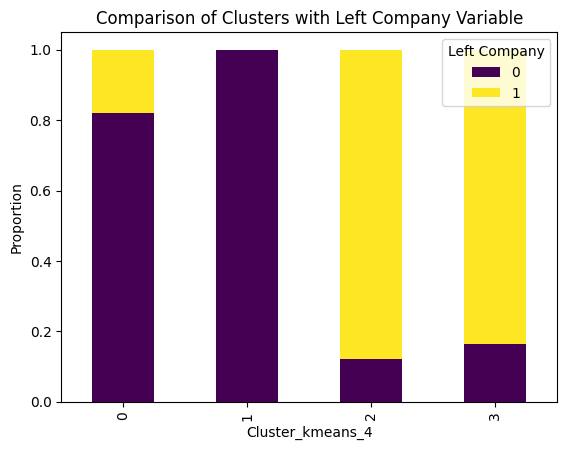

In [39]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Three clusters

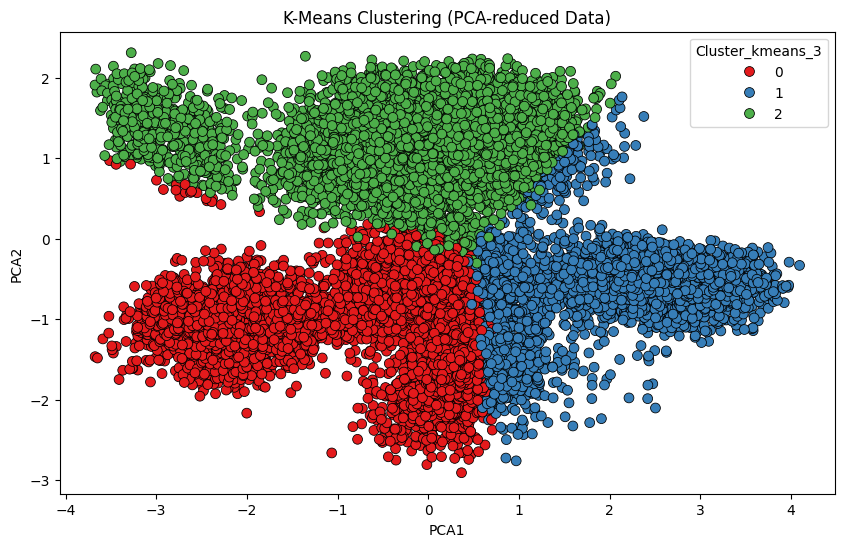

In [40]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_3 = KMeans(n_clusters=3, random_state=42)
data['Cluster_kmeans_3'] = kmeans_3.fit_predict(X_scaled)
X_cluster['Cluster_kmeans_3']=data['Cluster_kmeans_3']

pca_df['Cluster_kmeans_3'] = data['Cluster_kmeans_3']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_3', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_3')
plt.show()

In [41]:
X_cluster.groupby('Cluster_kmeans_3').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_kmeans_3                                                     
0                      0.490307          4.045355         0.301067   
1                      0.505239          3.609365         0.677805   
2                      0.505327          4.016520         0.714733   

                  number_project  average_montly_hours  time_spend_company  \
Cluster_kmeans_3                                                             
0                       0.237345              0.397771            0.271580   
1                       0.653635              0.691364            1.233792   
2                       0.326509              0.474975            0.342751   

                  work_accident  promotion_last_5years    gender  \
Cluster_kmeans_3                                                   
0                      0.148135               0.023775  0.507315   
1                      0.093648               0.007204  0.506876   
2                      0.165663               0.025784  0.505481   

                  linkedin_hits  ...  role_Director  role_Level 1  \
Cluster_kmeans_3                 ...                                
0                      0.491185  ...       0.045355      0.216898   
1                      0.220873  ...       0.045842      0.221676   
2                      0.116347  ...       0.041995      0.217230   

                  role_Level 2-4  role_Manager  role_Senior Director  \
Cluster_kmeans_3                                                       
0                       0.466715      0.155267              0.023409   
1                       0.447610      0.170596              0.021611   
2                       0.458546      0.162112              0.020997   

                  role_Senior Manager   role_VP  left_company  \
Cluster_kmeans_3                                                
0                            0.085040  0.007315      0.199707   
1                            0.083497  0.009168      0.641454   
2                            0.092635  0.006484      0.080284   

                  Cluster_kmeans_5  Cluster_kmeans_4  
Cluster_kmeans_3                                      
0                         1.516459          0.008230  
1                         1.664375          2.336280  
2                         3.160414          1.084607  

[3 rows x 48 columns]

Comparison Table:
 left_company             0         1
Cluster_kmeans_3                    
0                 0.800293  0.199707
1                 0.358546  0.641454
2                 0.919716  0.080284


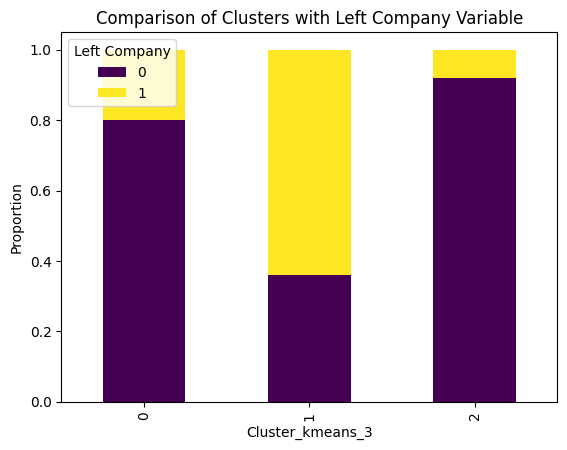

In [42]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Two custers

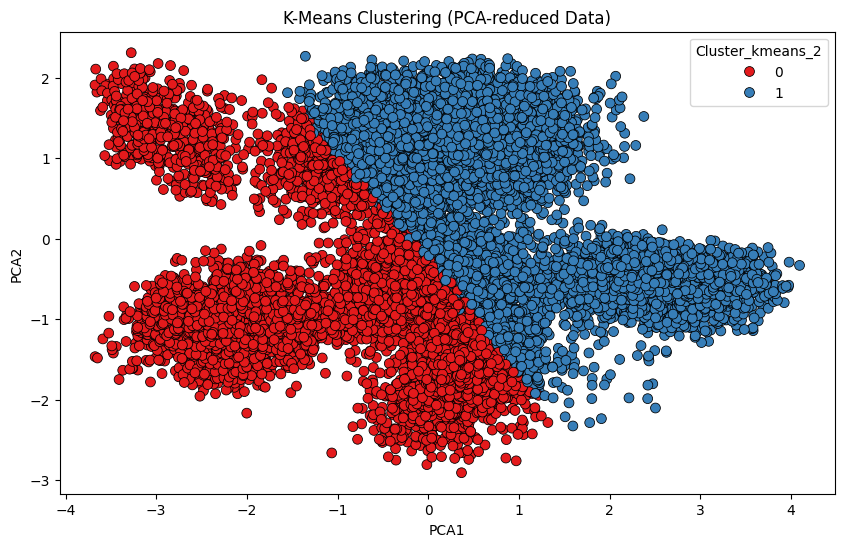

In [43]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_2 = KMeans(n_clusters=2, random_state=42)
data['Cluster_kmeans_2'] = kmeans_2.fit_predict(X_scaled)
X_cluster['Cluster_kmeans_2']=data['Cluster_kmeans_2']
pca_df['Cluster_kmeans_2'] = data['Cluster_kmeans_2']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_2', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_2')
plt.show()

In [44]:
X_cluster.groupby('Cluster_kmeans_2').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_kmeans_2                                                     
0                      0.497376          4.185780         0.315848   
1                      0.501607          3.769743         0.730010   

                  number_project  average_montly_hours  time_spend_company  \
Cluster_kmeans_2                                                             
0                       0.217624              0.349466            0.271990   
1                       0.463797              0.592947            0.661501   

                  work_accident  promotion_last_5years    gender  \
Cluster_kmeans_2                                                   
0                      0.142198               0.022268  0.513440   
1                      0.146350               0.020546  0.501377   

                  linkedin_hits  ...  role_Level 1  role_Level 2-4  \
Cluster_kmeans_2                 ...                                 
0                      0.461523  ...      0.217751        0.465564   
1                      0.139156  ...      0.218205        0.454775   

                  role_Manager  role_Senior Director  role_Senior Manager  \
Cluster_kmeans_2                                                            
0                     0.157627              0.022109             0.087323   
1                     0.164027              0.021924             0.088499   

                   role_VP  left_company  Cluster_kmeans_5  Cluster_kmeans_4  \
Cluster_kmeans_2                                                               
0                 0.007158      0.257675          1.728010          0.276125   
1                 0.007461      0.223944          2.637856          1.431244   

                  Cluster_kmeans_3  
Cluster_kmeans_2                    
0                         0.363767  
1                         1.574954  

[2 rows x 49 columns]

Comparison Table:
 left_company             0         1
Cluster_kmeans_2                    
0                 0.742325  0.257675
1                 0.776056  0.223944


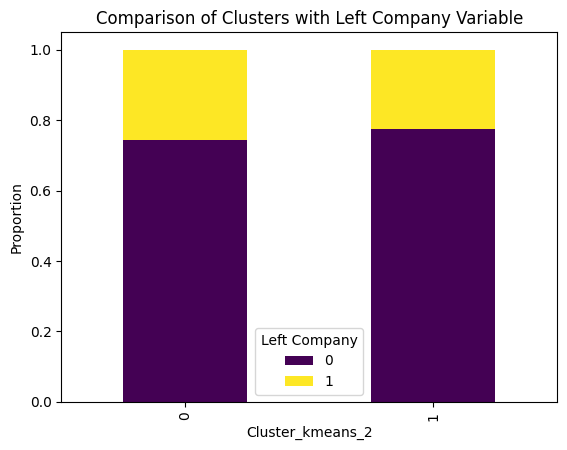

In [45]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Six clusters

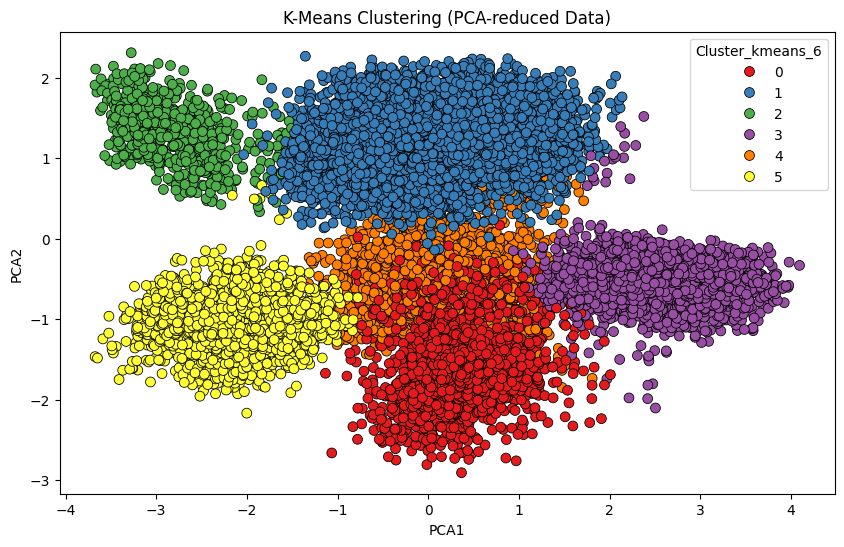

In [46]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_6 = KMeans(n_clusters=6, random_state=42)
data['Cluster_kmeans_6'] = kmeans_6.fit_predict(X_scaled)
X_cluster['Cluster_kmeans_6']=data['Cluster_kmeans_6']
pca_df['Cluster_kmeans_6'] = data['Cluster_kmeans_6']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_6', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_6')
plt.show()

In [47]:
X_cluster.groupby('Cluster_kmeans_6').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_kmeans_6                                                     
0                      0.507883          3.588629         0.344041   
1                      0.505592          4.000000         0.769079   
2                      0.533898          4.911864         0.264778   
3                      0.493840          3.981253         0.833682   
4                      0.491557          3.590619         0.352046   
5                      0.482056          4.296314         0.278333   

                  number_project  average_montly_hours  time_spend_company  \
Cluster_kmeans_6                                                             
0                       0.436885              0.329318            0.420927   
1                       0.365292              0.493143            0.381510   
2                       0.004407              0.218597            0.033898   
3                       0.677772              0.770540            1.595608   
4                       0.364953              0.677505            0.396998   
5                       0.079340              0.232154            0.170708   

                  work_accident  promotion_last_5years    gender  \
Cluster_kmeans_6                                                   
0                      0.166746               0.022456  0.503583   
1                      0.175638               0.028487  0.504020   
2                      0.059322               0.006780  0.544068   
3                      0.049277               0.002142  0.506160   
4                      0.166229               0.022514  0.495685   
5                      0.118817               0.019884  0.519399   

                  linkedin_hits  ...  role_Level 2-4  role_Manager  \
Cluster_kmeans_6                 ...                                 
0                      0.477761  ...        0.460583      0.164357   
1                      0.070812  ...        0.459804      0.162181   
2                      0.475689  ...        0.430508      0.159322   
3                      0.076058  ...        0.458490      0.160686   
4                      0.479368  ...        0.451407      0.166229   
5                      0.489141  ...        0.475752      0.150824   

                  role_Senior Director  role_Senior Manager   role_VP  \
Cluster_kmeans_6                                                        
0                             0.025800             0.083134  0.007645   
1                             0.021146             0.092974  0.006641   
2                             0.016949             0.100000  0.005085   
3                             0.023567             0.079272  0.007499   
4                             0.019137             0.087430  0.007880   
5                             0.024248             0.084384  0.008729   

                  left_company  Cluster_kmeans_5  Cluster_kmeans_4  \
Cluster_kmeans_6                                                     
0                     0.070712          1.318204          0.333015   
1                     0.000524          3.333799          1.003495   
2                     0.911864          2.145763          2.000000   
3                     0.988216          1.960900          3.000000   
4                     0.019137          1.384240          0.365854   
5                     0.478177          1.645975          0.004850   

                  Cluster_kmeans_3  Cluster_kmeans_2  
Cluster_kmeans_6                                      
0                         0.259914          0.161013  
1                         1.981999          0.924327  
2                         1.925424          0.000000  
3                         1.000000          1.000000  
4                         0.415009          0.457411  
5                         0.006790          0.000000  

[6 rows x 50 columns]

Comparison Table:
 left_company             0         1
Cluster_kmeans_6                    
0                 0.929288  0.070712
1                 0.999476  0.000524
2                 0.088136  0.911864
3                 0.011784  0.988216
4                 0.980863  0.019137
5                 0.521823  0.478177


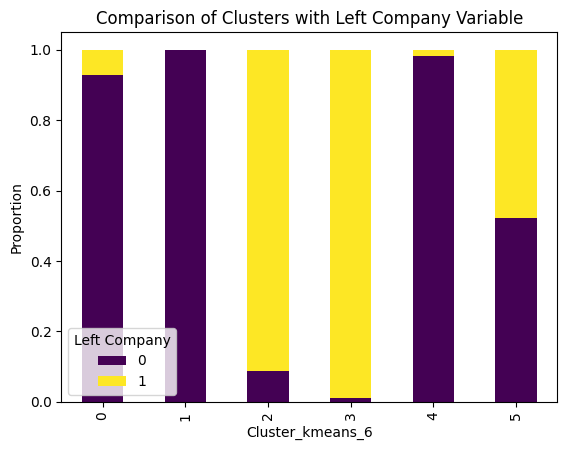

In [48]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_6', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_6'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_6')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Comparing the number of clusters

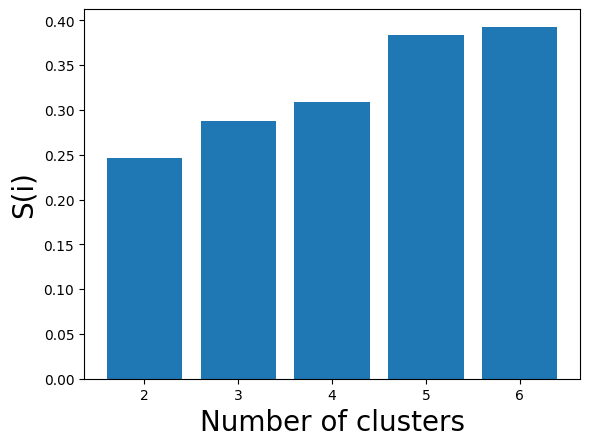

In [49]:
# Could be used here as well
#Using Silhouette Scores to identify the right number of clusters
k = [2,3,4,5,6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(X_scaled, kmeans_2.fit_predict(X_scaled))) 
silhouette_scores.append( 
        silhouette_score(X_scaled, kmeans_3.fit_predict(X_scaled))) 
silhouette_scores.append( 
        silhouette_score(X_scaled, kmeans_4.fit_predict(X_scaled))) 
silhouette_scores.append( 
        silhouette_score(X_scaled, kmeans_5.fit_predict(X_scaled))) 
silhouette_scores.append( 
        silhouette_score(X_scaled, kmeans_6.fit_predict(X_scaled))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 

## AgglomerativeClustering

### PCA

In [50]:
# PCA

pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['PCA1', 'PCA2'] 


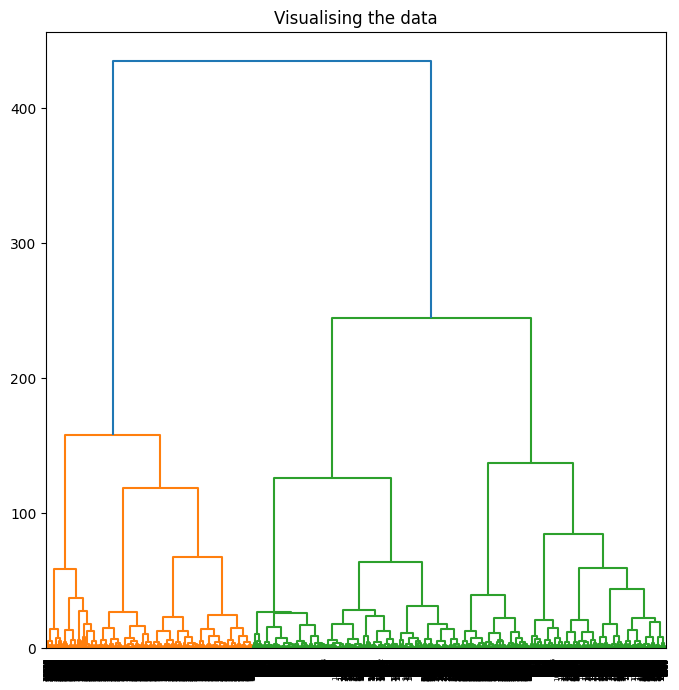

In [51]:
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward'))) 

### Two Clusters

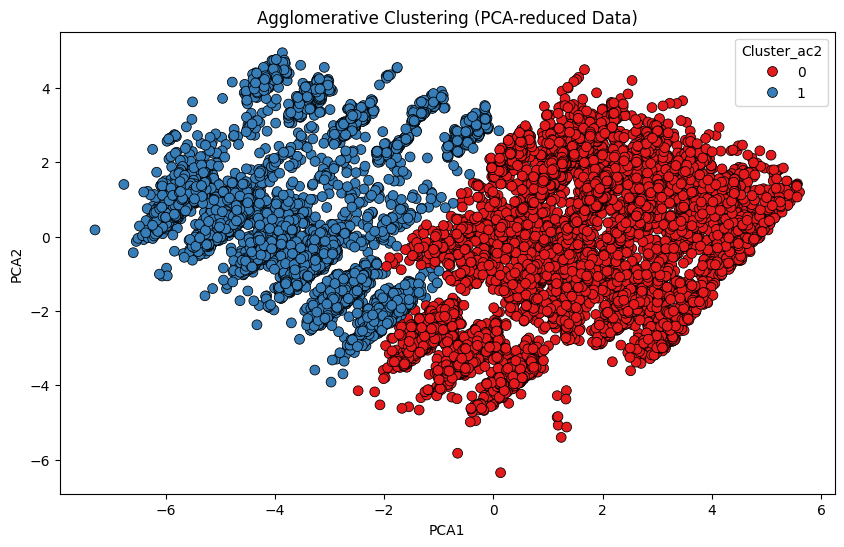

In [52]:
#Agglomerative Clustering / Ward hierarchical clustering
ac2 = AgglomerativeClustering(n_clusters = 2) 
# plt.figure(figsize =(6, 6)) 
# plt.scatter(X_principal['PCA1'], X_principal['PCA2'],  
#            c = ac2.fit_predict(X_principal), cmap ='rainbow') 
# plt.show()

data['Cluster_ac2'] = ac2.fit_predict(X_principal)
ac2_df = pd.DataFrame(data=X_principal, columns=['PCA1', 'PCA2'])
ac2_df['Cluster_ac2'] = data['Cluster_ac2']
X_cluster['Cluster_ac2']=data['Cluster_ac2']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac2_df, x='PCA1', y='PCA2', hue='Cluster_ac2', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac2')
plt.show()


In [53]:
X_cluster.groupby('Cluster_ac2').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  number_project  \
Cluster_ac2                                                                     
0                 0.495697          3.916950         0.444951        0.329718   
1                 0.508092          3.998402         0.778968        0.422298   

             average_montly_hours  time_spend_company  work_accident  \
Cluster_ac2                                                            
0                        0.461609            0.437162       0.142586   
1                        0.549357            0.620180       0.148651   

             promotion_last_5years    gender  linkedin_hits  ...  \
Cluster_ac2                                                  ...   
0                         0.020412  0.508905       0.375683  ...   
1                         0.022977  0.501499       0.071797  ...   

             role_Manager  role_Senior Director  role_Senior Manager  \
Cluster_ac2                                                            
0                0.161797              0.022714             0.088253   
1                0.160440              0.020579             0.087512   

              role_VP  left_company  Cluster_kmeans_5  Cluster_kmeans_4  \
Cluster_ac2                                                               
0            0.006904      0.253052          1.868921          0.709826   
1            0.008192      0.208192          3.030370          1.420779   

             Cluster_kmeans_3  Cluster_kmeans_2  Cluster_kmeans_6  
Cluster_ac2                                                        
0                    0.715029          0.405543          2.617871  
1                    1.770629          0.930869          1.460539  

[2 rows x 51 columns]

In [54]:
cluster_distribution = data['Cluster_ac2'].value_counts().sort_index()
cluster_distribution

Cluster_ac2
0    9994
1    5005
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_ac2                     
0             0.746948  0.253052
1             0.791808  0.208192


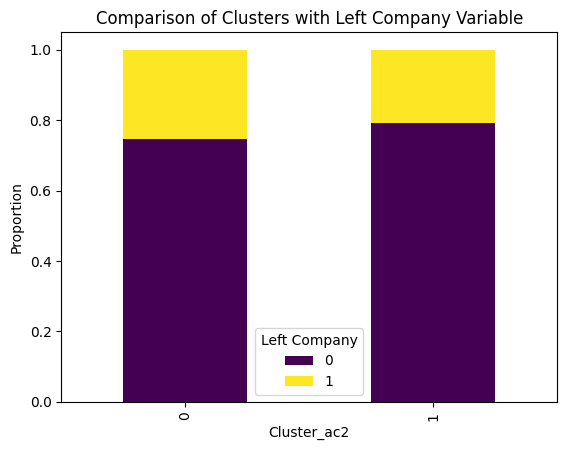

In [55]:
comparison_df = data[['Cluster_ac2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Three Clusters

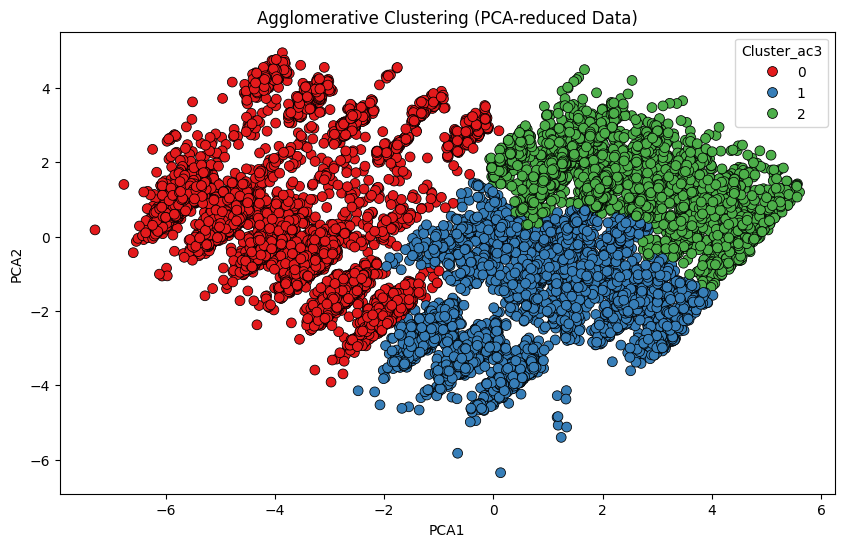

In [56]:
ac3 = AgglomerativeClustering(n_clusters = 3) 
data['Cluster_ac3'] = ac3.fit_predict(X_principal)
ac3_df = pd.DataFrame(data=X_principal, columns=['PCA1', 'PCA2'])
ac3_df['Cluster_ac3'] = data['Cluster_ac3']
X_cluster['Cluster_ac3']=data['Cluster_ac3']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac3_df, x='PCA1', y='PCA2', hue='Cluster_ac3', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac3')
plt.show()


In [57]:
X_cluster.groupby('Cluster_ac3').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  number_project  \
Cluster_ac3                                                                     
0                 0.508092          3.998402         0.778968        0.422298   
1                 0.500101          4.008285         0.512114        0.372156   
2                 0.491378          3.827354         0.379067        0.288087   

             average_montly_hours  time_spend_company  work_accident  \
Cluster_ac3                                                            
0                        0.549357            0.620180       0.148651   
1                        0.421439            0.340473       0.154577   
2                        0.501014            0.532012       0.130823   

             promotion_last_5years    gender  linkedin_hits  ...  \
Cluster_ac3                                                  ...   
0                         0.022977  0.501499       0.071797  ...   
1                         0.033744  0.507375       0.302362  ...   
2                         0.007334  0.510406       0.447609  ...   

             role_Senior Director  role_Senior Manager   role_VP  \
Cluster_ac3                                                        
0                        0.020579             0.087512  0.008192   
1                        0.024247             0.092140  0.006062   
2                        0.021209             0.084440  0.007730   

             left_company  Cluster_kmeans_5  Cluster_kmeans_4  \
Cluster_ac3                                                     
0                0.208192          3.030370          1.420779   
1                0.172358          2.393413          0.880178   
2                0.332210          1.354410          0.542716   

             Cluster_kmeans_3  Cluster_kmeans_2  Cluster_kmeans_6  Cluster_ac2  
Cluster_ac3                                                                     
0                    1.770629          0.930869          1.460539          1.0  
1                    1.156597          0.486159          0.992928          0.0  
2                    0.281863          0.326462          4.211893          0.0  

[3 rows x 52 columns]

In [58]:
cluster_distribution = data['Cluster_ac3'].value_counts().sort_index()
cluster_distribution

Cluster_ac3
0    5005
1    4949
2    5045
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_ac3                     
0             0.791808  0.208192
1             0.827642  0.172358
2             0.667790  0.332210


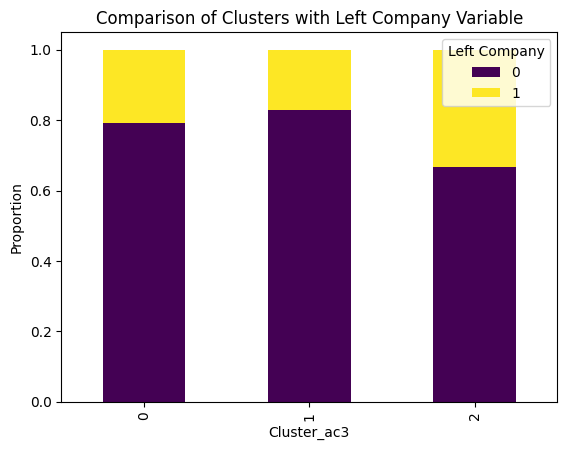

In [59]:
comparison_df = data[['Cluster_ac3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Four clusters

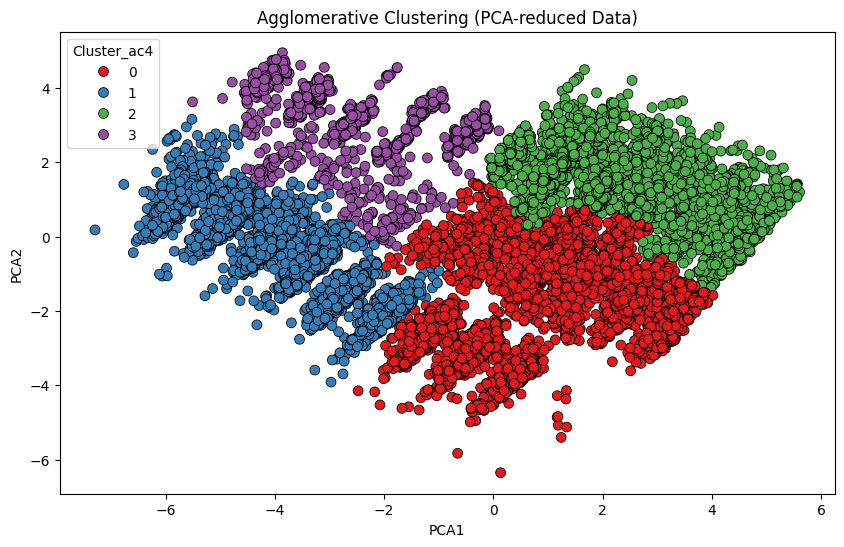

In [60]:
ac4 = AgglomerativeClustering(n_clusters = 4) 
data['Cluster_ac4'] = ac4.fit_predict(X_principal)
ac4_df = pd.DataFrame(data=X_principal, columns=['PCA1', 'PCA2'])
ac4_df['Cluster_ac4'] = data['Cluster_ac4']
X_cluster['Cluster_ac4']=data['Cluster_ac4']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac4_df, x='PCA1', y='PCA2', hue='Cluster_ac4', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac4')
plt.show()

In [61]:
X_cluster.groupby('Cluster_ac4').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  number_project  \
Cluster_ac4                                                                     
0                 0.500101          4.008285         0.512114        0.372156   
1                 0.512500          3.999202         0.766336        0.360532   
2                 0.491378          3.827354         0.379067        0.288087   
3                 0.494779          3.995984         0.817118        0.608835   

             average_montly_hours  time_spend_company  work_accident  \
Cluster_ac4                                                            
0                        0.421439            0.340473       0.154577   
1                        0.492096            0.183777       0.174734   
2                        0.501014            0.532012       0.130823   
3                        0.722291            1.938153       0.069880   

             promotion_last_5years    gender  linkedin_hits  ...  \
Cluster_ac4                                                  ...   
0                         0.033744  0.507375       0.302362  ...   
1                         0.028723  0.501064       0.071572  ...   
2                         0.007334  0.510406       0.447609  ...   
3                         0.005622  0.502811       0.072477  ...   

             role_Senior Manager   role_VP  left_company  Cluster_kmeans_5  \
Cluster_ac4                                                                  
0                       0.092140  0.006062      0.172358          2.393413   
1                       0.088298  0.007979      0.003457          3.284309   
2                       0.084440  0.007730      0.332210          1.354410   
3                       0.085141  0.008835      0.826506          2.263454   

             Cluster_kmeans_4  Cluster_kmeans_3  Cluster_kmeans_2  \
Cluster_ac4                                                         
0                    0.880178          1.156597          0.486159   
1                    1.013564          1.977660          0.916489   
2                    0.542716          0.281863          0.326462   
3                    2.650602          1.145382          0.974297   

             Cluster_kmeans_6  Cluster_ac2  Cluster_ac3  
Cluster_ac4                                              
0                    0.992928          0.0          1.0  
1                    1.024468          1.0          0.0  
2                    4.211893          0.0          2.0  
3                    2.777510          1.0          0.0  

[4 rows x 53 columns]

In [62]:
cluster_distribution = data['Cluster_ac4'].value_counts().sort_index()
cluster_distribution

Cluster_ac4
0    4949
1    3760
2    5045
3    1245
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_ac4                     
0             0.827642  0.172358
1             0.996543  0.003457
2             0.667790  0.332210
3             0.173494  0.826506


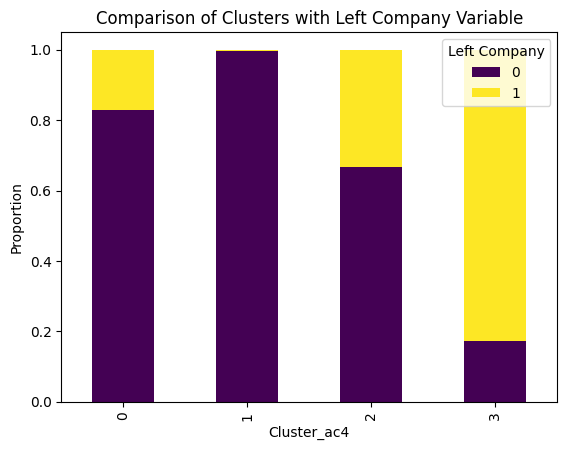

In [63]:
comparison_df = data[['Cluster_ac4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Five clusters

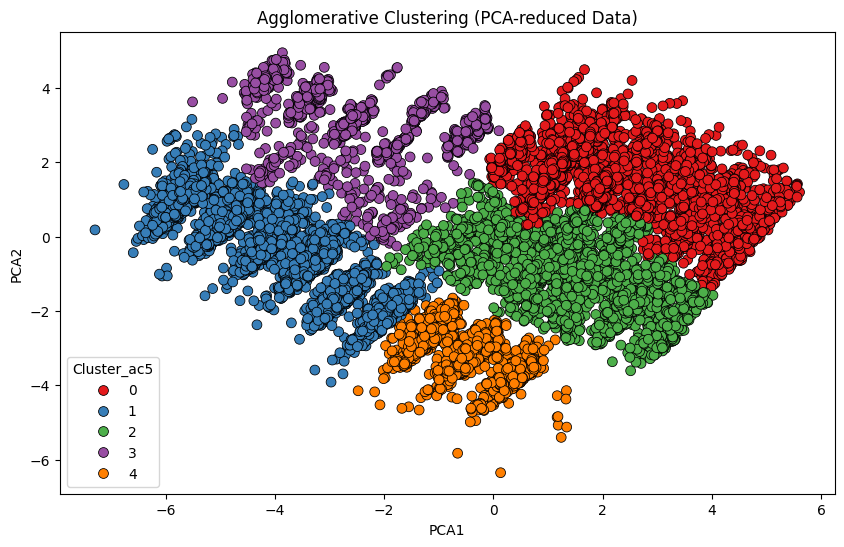

In [64]:
ac5 = AgglomerativeClustering(n_clusters = 5) 
data['Cluster_ac5'] = ac5.fit_predict(X_principal)
ac5_df = pd.DataFrame(data=X_principal, columns=['PCA1', 'PCA2'])
ac5_df['Cluster_ac5'] = data['Cluster_ac5']
X_cluster['Cluster_ac5']=data['Cluster_ac5']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac5_df, x='PCA1', y='PCA2', hue='Cluster_ac5', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac5')
plt.show()

In [65]:
X_cluster.groupby('Cluster_ac5').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  number_project  \
Cluster_ac5                                                                     
0                 0.491378          3.827354         0.379067        0.288087   
1                 0.512500          3.999202         0.766336        0.360532   
2                 0.505947          4.007319         0.388252        0.375236   
3                 0.494779          3.995984         0.817118        0.608835   
4                 0.488623          4.010180         0.755314        0.366108   

             average_montly_hours  time_spend_company  work_accident  \
Cluster_ac5                                                            
0                        0.501014            0.532012       0.130823   
1                        0.492096            0.183777       0.174734   
2                        0.385328            0.507777       0.143641   
3                        0.722291            1.938153       0.069880   
4                        0.492341            0.011976       0.176048   

             promotion_last_5years    gender  linkedin_hits  ...   role_VP  \
Cluster_ac5                                                  ...             
0                         0.007334  0.510406       0.447609  ...  0.007730   
1                         0.028723  0.501064       0.071572  ...  0.007979   
2                         0.021958  0.513266       0.415580  ...  0.006709   
3                         0.005622  0.502811       0.072477  ...  0.008835   
4                         0.056886  0.495808       0.080062  ...  0.004790   

             left_company  Cluster_kmeans_5  Cluster_kmeans_4  \
Cluster_ac5                                                     
0                0.332210          1.354410          0.542716   
1                0.003457          3.284309          1.013564   
2                0.259225          1.577005          0.820982   
3                0.826506          2.263454          2.650602   
4                0.001796          3.996407          0.996407   

             Cluster_kmeans_3  Cluster_kmeans_2  Cluster_kmeans_6  \
Cluster_ac5                                                         
0                    0.281863          0.326462          4.211893   
1                    1.977660          0.916489          1.024468   
2                    0.757548          0.275389          0.985666   
3                    1.145382          0.974297          2.777510   
4                    1.940120          0.900000          1.007186   

             Cluster_ac2  Cluster_ac3  Cluster_ac4  
Cluster_ac5                                         
0                    0.0          2.0          2.0  
1                    1.0          0.0          1.0  
2                    0.0          1.0          0.0  
3                    1.0          0.0          3.0  
4                    0.0          1.0          0.0  

[5 rows x 54 columns]

In [66]:
cluster_distribution = data['Cluster_ac5'].value_counts().sort_index()
cluster_distribution

Cluster_ac5
0    5045
1    3760
2    3279
3    1245
4    1670
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_ac5                     
0             0.667790  0.332210
1             0.996543  0.003457
2             0.740775  0.259225
3             0.173494  0.826506
4             0.998204  0.001796


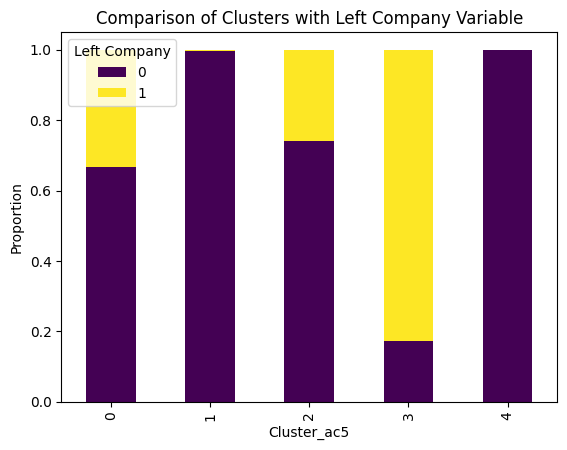

In [67]:
comparison_df = data[['Cluster_ac5', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac5'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac5')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Six clusters

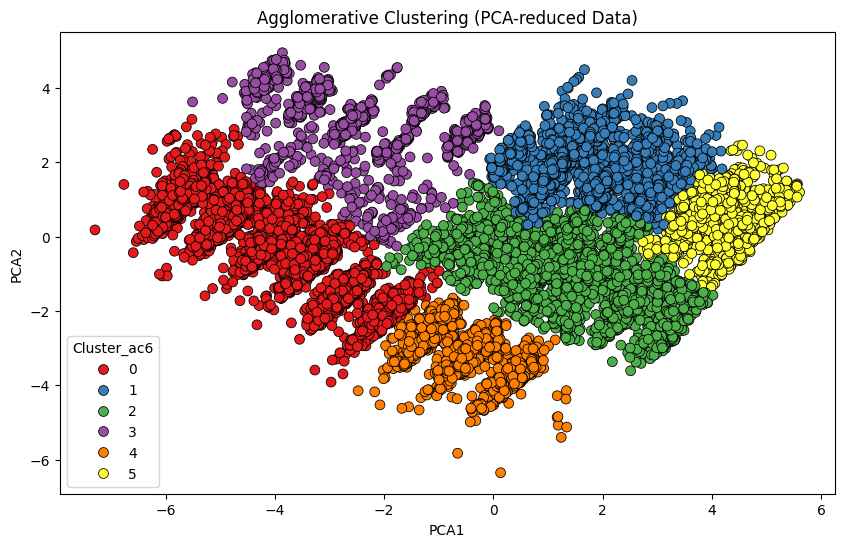

In [68]:
ac6 = AgglomerativeClustering(n_clusters = 6) 
data['Cluster_ac6'] = ac6.fit_predict(X_principal)
ac6_df = pd.DataFrame(data=X_principal, columns=['PCA1', 'PCA2'])
ac6_df['Cluster_ac6'] = data['Cluster_ac6']
X_cluster['Cluster_ac6']=data['Cluster_ac6']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac6_df, x='PCA1', y='PCA2', hue='Cluster_ac6', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac6')
plt.show()

In [69]:
X_cluster.groupby('Cluster_ac6').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  number_project  \
Cluster_ac6                                                                     
0                 0.512500          3.999202         0.766336        0.360532   
1                 0.495605          3.786905         0.416201        0.320339   
2                 0.505947          4.007319         0.388252        0.375236   
3                 0.494779          3.995984         0.817118        0.608835   
4                 0.488623          4.010180         0.755314        0.366108   
5                 0.483391          3.903780         0.308902        0.227148   

             average_montly_hours  time_spend_company  work_accident  \
Cluster_ac6                                                            
0                        0.492096            0.183777       0.174734   
1                        0.522938            0.695362       0.124280   
2                        0.385328            0.507777       0.143641   
3                        0.722291            1.938153       0.069880   
4                        0.492341            0.011976       0.176048   
5                        0.459590            0.223368       0.143184   

             promotion_last_5years    gender  linkedin_hits  ...  \
Cluster_ac6                                                  ...   
0                         0.028723  0.501064       0.071572  ...   
1                         0.006062  0.503789       0.423788  ...   
2                         0.021958  0.513266       0.415580  ...   
3                         0.005622  0.502811       0.072477  ...   
4                         0.056886  0.495808       0.080062  ...   
5                         0.009737  0.522910       0.492617  ...   

             left_company  Cluster_kmeans_5  Cluster_kmeans_4  \
Cluster_ac6                                                     
0                0.003457          3.284309          1.013564   
1                0.382237          1.313731          0.764171   
2                0.259225          1.577005          0.820982   
3                0.826506          2.263454          2.650602   
4                0.001796          3.996407          0.996407   
5                0.237686          1.431271          0.124284   

             Cluster_kmeans_3  Cluster_kmeans_2  Cluster_kmeans_6  \
Cluster_ac6                                                         
0                    1.977660          0.916489          1.024468   
1                    0.345862          0.387693          4.107002   
2                    0.757548          0.275389          0.985666   
3                    1.145382          0.974297          2.777510   
4                    1.940120          0.900000          1.007186   
5                    0.160939          0.210767          4.410080   

             Cluster_ac2  Cluster_ac3  Cluster_ac4  Cluster_ac5  
Cluster_ac6                                                      
0                    1.0          0.0          1.0          1.0  
1                    0.0          2.0          2.0          0.0  
2                    0.0          1.0          0.0          2.0  
3                    1.0          0.0          3.0          3.0  
4                    0.0          1.0          0.0          4.0  
5                    0.0          2.0          2.0          0.0  

[6 rows x 55 columns]

In [70]:
cluster_distribution = data['Cluster_ac6'].value_counts().sort_index()
cluster_distribution

Cluster_ac6
0    3760
1    3299
2    3279
3    1245
4    1670
5    1746
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_ac6                     
0             0.996543  0.003457
1             0.617763  0.382237
2             0.740775  0.259225
3             0.173494  0.826506
4             0.998204  0.001796
5             0.762314  0.237686


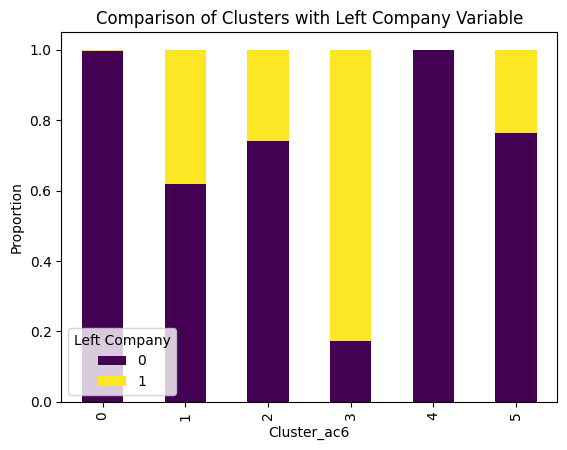

In [71]:
comparison_df = data[['Cluster_ac6', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac6'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac6')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

## Comparing number of clusters

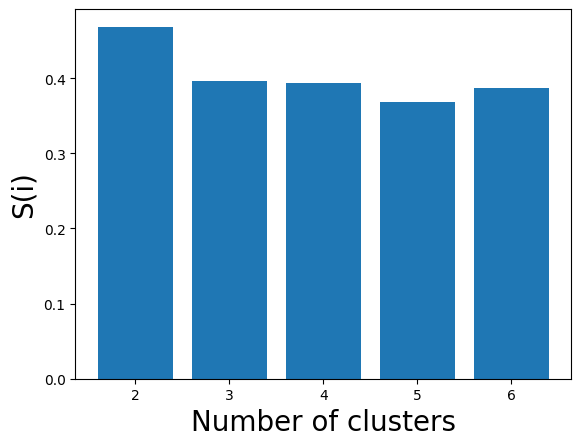

In [72]:
# Using Silhouette Scores to identify the right number of clusters
k = [2, 3, 4, 5, 6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(X_principal, ac2.fit_predict(X_principal))) 
silhouette_scores.append( 
        silhouette_score(X_principal, ac3.fit_predict(X_principal))) 
silhouette_scores.append( 
        silhouette_score(X_principal, ac4.fit_predict(X_principal))) 
silhouette_scores.append( 
        silhouette_score(X_principal, ac5.fit_predict(X_principal))) 
silhouette_scores.append( 
        silhouette_score(X_principal, ac6.fit_predict(X_principal))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 

## DBSCAN Clustering

### k-distance graph

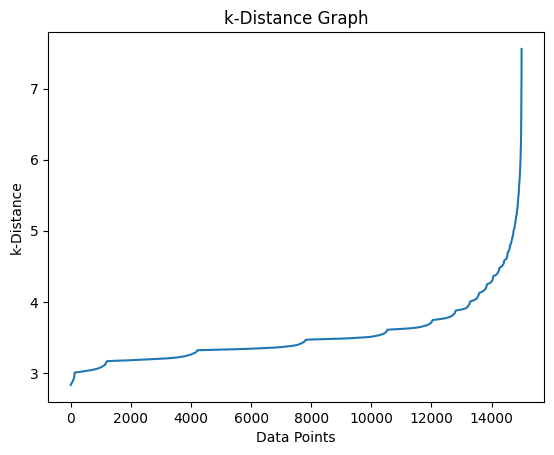

In [73]:
# estimating eps value 
k = 9  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [74]:

eps = 3.75  
min_samples = 10

#Run DBSCAN and evaluate
db_1 = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
core_samples_mask = np.zeros_like(db_1.labels_, dtype=bool)
core_samples_mask[db_1.core_sample_indices_] = True
labels = db_1.labels_
data['Cluster_db_1'] = db_1.fit_predict(X) 
X_cluster['Cluster_db_1']=data['Cluster_db_1']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_1.fit_predict(X)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")



Silhouette Score: 0.21038423650087992


In [75]:
X_cluster.groupby('Cluster_db_1').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_db_1                                                     
-1                 0.504386          3.276316         0.535979   
 0                 0.482275          5.000000         0.251005   
 1                 0.516877          4.851385         0.330825   
 2                 0.487164          5.000000         0.249310   
 3                 0.445122          5.000000         0.264482   
 4                 0.497765          4.076006         0.796735   
 5                 0.481675          1.000000         0.461428   
 6                 0.511924          1.000000         0.466340   
 7                 0.502101          1.000000         0.462677   
 8                 0.500000          1.000000         0.507812   
 9                 0.000000          1.000000         0.484375   
 10                0.488764          4.000000         0.766737   
 11                0.509618          4.000000         0.768809   
 12                0.490040          4.000000         0.843750   
 13                0.800000          4.000000         0.792188   

              number_project  average_montly_hours  time_spend_company  \
Cluster_db_1                                                             
-1                  0.434336              0.502969            2.486842   
 0                  0.188458              0.430885            0.086562   
 1                  0.340655              0.353909            0.246348   
 2                  0.176716              0.412738            0.162985   
 3                  0.358537              0.657482           -0.591463   
 4                  0.661401              0.768897            1.718331   
 5                  0.276963              0.513664           -0.138743   
 6                  0.282353              0.539159           -0.147854   
 7                  0.378992              0.329155           -0.130252   
 8                  0.300000              0.790888            0.000000   
 9                  0.200000              0.696262            0.000000   
 10                 0.364669              0.495193           -0.021848   
 11                 0.359130              0.490481            0.049624   
 12                 0.667928              0.763758            1.606574   
 13                 0.400000              0.449065            3.300000   

              work_accident  promotion_last_5years    gender  linkedin_hits  \
Cluster_db_1                                                                  
-1                 0.187970               0.132206  0.481830       0.305529   
 0                 0.134378               0.003298  0.516076       0.490635   
 1                 0.126448               0.000504  0.515869       0.436847   
 2                 0.118209               0.000000  0.502090       0.500075   
 3                 0.158537               0.000000  0.512195       0.465320   
 4                 0.049180               0.000000  0.527571       0.098337   
 5                 0.143979               0.005236  0.541885       0.501473   
 6                 0.179650               0.001590  0.496025       0.510980   
 7                 0.159664               0.000000  0.521008       0.483751   
 8                 0.000000               0.000000  1.000000       0.460938   
 9                 0.000000               0.000000  0.000000       0.187500   
 10                0.174157               0.025593  0.503745       0.070088   
 11                0.173962               0.016448  0.503206       0.070728   
 12                0.049801               0.000000  0.503984       0.071838   
 13                0.100000               0.000000  0.900000       0.071875   

              ...  Cluster_kmeans_5  Cluster_kmeans_4  Cluster_kmeans_3  \
Cluster_db_1  ...                                                         
-1            ...          1.525689          1.236216          1.164787   
 0            ...          1.987634          0.001649          

In [76]:
cluster_distribution = data['Cluster_db_1'].value_counts().sort_index()
cluster_distribution

Cluster_db_1
-1     1596
 0     1213
 1     1985
 2     1675
 3      164
 4      671
 5      382
 6      629
 7      476
 8        4
 9        1
 10    1602
 11    3587
 12    1004
 13      10
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_1                    
-1            0.917920  0.082080
 0            0.672712  0.327288
 1            0.604030  0.395970
 2            0.641791  0.358209
 3            1.000000  0.000000
 4            0.053651  0.946349
 5            0.986911  0.013089
 6            0.988871  0.011129
 7            0.987395  0.012605
 8            1.000000  0.000000
 9            1.000000  0.000000
 10           1.000000  0.000000
 11           0.999442  0.000558
 12           0.001992  0.998008
 13           1.000000  0.000000


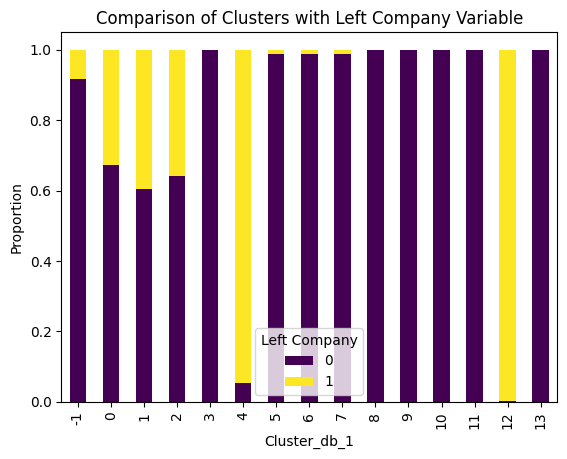

In [77]:
comparison_df = data[['Cluster_db_1', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_1'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_1')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### k-distance graph

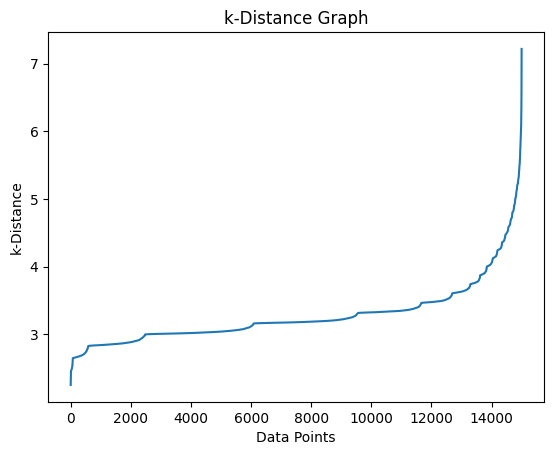

In [78]:
# estimating eps value 
k = 4  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [79]:

eps = 3.75  
min_samples = 5

#Run DBSCAN and evaluate
db_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
core_samples_mask = np.zeros_like(db_2.labels_, dtype=bool)
core_samples_mask[db_2.core_sample_indices_] = True
labels = db_2.labels_
data['Cluster_db_2'] = db_2.fit_predict(X)
X_cluster['Cluster_db_2']=data['Cluster_db_2']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_2.fit_predict(X)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

Silhouette Score: 0.23960041823639097


In [80]:
X_cluster.groupby('Cluster_db_2').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_db_2                                                     
-1                 0.512231          3.375093         0.522111   
 0                 0.482730          5.000000         0.250784   
 1                 0.516600          4.851610         0.330852   
 2                 0.487164          5.000000         0.249310   
 3                 0.445122          5.000000         0.264482   
 4                 0.497765          4.076006         0.796735   
 5                 0.166667          5.000000         0.309896   
 6                 0.481675          1.000000         0.461428   
 7                 0.511924          1.000000         0.466340   
 8                 0.502101          1.000000         0.462677   
 9                 0.492537          1.000000         0.469216   
 10                0.444444          1.000000         0.462674   
 11                0.100000          1.000000         0.462500   
 12                0.400000          1.000000         0.465625   
 13                0.285714          1.000000         0.473214   
 14                1.000000          1.000000         0.494792   
 15                0.488764          4.000000         0.766737   
 16                0.509618          4.000000         0.768809   
 17                0.375000          4.000000         0.589844   
 18                0.490040          4.000000         0.843750   
 19                0.800000          4.000000         0.792188   
 20                0.400000          4.000000         0.578125   
 21                0.642857          4.000000         0.784598   
 22                0.315789          4.000000         0.743421   
 23                0.600000          4.000000         0.750000   
 24                0.375000          4.000000         0.849609   
 25                0.407407          4.000000         0.802083   
 26                0.142857          4.000000         0.729911   
 27                0.800000          4.000000         0.809375   
 28                0.500000          4.000000         0.841146   
 29                0.750000          4.000000         0.757812   
 30                0.600000          4.000000         0.815625   

              number_project  average_montly_hours  time_spend_company  \
Cluster_db_2                                                             
-1                  0.422980              0.506924            2.651594   
 0                  0.188980              0.431209            0.096217   
 1                  0.340845              0.354042            0.252515   
 2                  0.176716              0.412738            0.162985   
 3                  0.358537              0.657482           -0.591463   
 4                  0.661401              0.768897            1.718331   
 5                  0.800000              0.431464            1.000000   
 6                  0.276963              0.513664           -0.138743   
 7                  0.282353              0.539159           -0.147854   
 8                  0.378992              0.329155           -0.130252   
 9                  0.617910              0.402636           -0.059701   
 10                 0.355556              0.339823           -0.111111   
 11                 0.620000              0.738318           -0.100000   
 12                 0.720000              0.753271            0.200000   
 13                 0.571429              0.747664            0.285714   
 14                 0.700000              0.790498            1.000000   
 15                 0.364669              0.495193           -0.021848   
 16                 0.359130              0.490481            0.049624   
 17                 0.350000              0.672897           -0.500000   
 18                 0.667928              0.763758            1.606574   
 19                 0.400000              0.449065            3.300000   
 20                 0.360000              0.773832           -0.200

In [81]:
cluster_distribution = data['Cluster_db_2'].value_counts().sort_index()
cluster_distribution

Cluster_db_2
-1     1349
 0     1216
 1     1988
 2     1675
 3      164
 4      671
 5        6
 6      382
 7      629
 8      476
 9       67
 10      18
 11      10
 12       5
 13       7
 14       6
 15    1602
 16    3587
 17       8
 18    1004
 19      10
 20       5
 21      28
 22      19
 23       5
 24       8
 25      27
 26       7
 27       5
 28       6
 29       4
 30       5
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_2                    
-1            0.908080  0.091920
 0            0.673520  0.326480
 1            0.604628  0.395372
 2            0.641791  0.358209
 3            1.000000  0.000000
 4            0.053651  0.946349
 5            0.500000  0.500000
 6            0.986911  0.013089
 7            0.988871  0.011129
 8            0.987395  0.012605
 9            0.955224  0.044776
 10           1.000000  0.000000
 11           1.000000  0.000000
 12           0.800000  0.200000
 13           1.000000  0.000000
 14           1.000000  0.000000
 15           1.000000  0.000000
 16           0.999442  0.000558
 17           1.000000  0.000000
 18           0.001992  0.998008
 19           1.000000  0.000000
 20           1.000000  0.000000
 21           1.000000  0.000000
 22           1.000000  0.000000
 23           1.000000  0.000000
 24           1.000000  0.000000
 25           1.000000  0.000000
 26           1.000000  

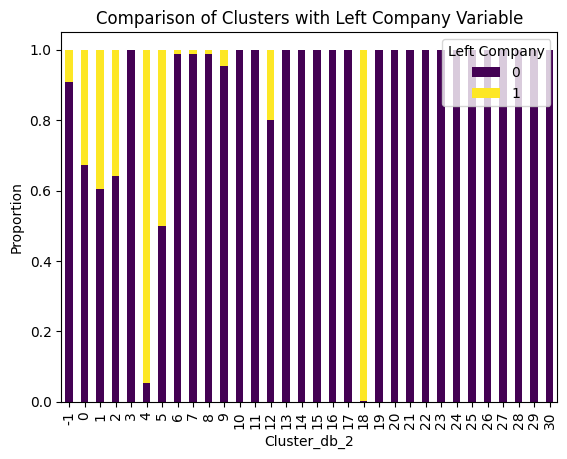

In [82]:
comparison_df = data[['Cluster_db_2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### k-distance graph

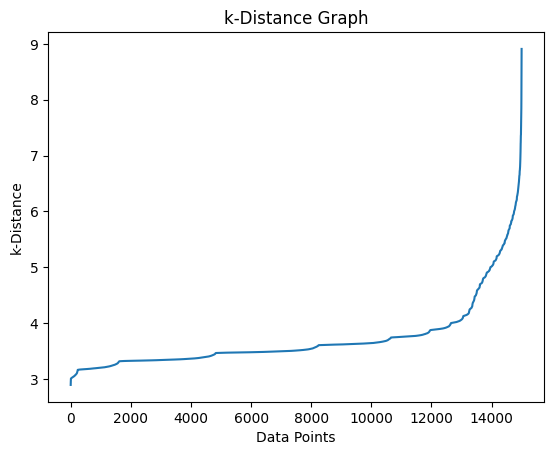

In [83]:
# estimating eps value 
k = 14  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [84]:

eps = 3.75  
min_samples = 15

#Run DBSCAN and evaluate
db_3 = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
core_samples_mask = np.zeros_like(db_3.labels_, dtype=bool)
core_samples_mask[db_3.core_sample_indices_] = True
labels = db_3.labels_
data['Cluster_db_3'] = db_3.fit_predict(X) 
X_cluster['Cluster_db_3']=data['Cluster_db_3']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_3.fit_predict(X)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

Silhouette Score: 0.236261324163046


In [85]:
X_cluster.groupby('Cluster_db_3').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_db_3                                                     
-1                 0.505453          3.253544         0.528609   
 0                 0.481266          5.000000         0.251288   
 1                 0.516912          4.978317         0.265273   
 2                 0.488471          5.000000         0.249716   
 3                 0.457516          5.000000         0.266033   
 4                 0.510996          4.694696         0.411223   
 5                 0.496263          4.073244         0.798346   
 6                 0.479651          1.000000         0.460847   
 7                 0.513393          1.000000         0.463135   
 8                 0.509121          1.000000         0.465822   
 9                 0.488416          4.000000         0.766691   
 10                0.509518          4.000000         0.768705   
 11                0.490040          4.000000         0.843750   

              number_project  average_montly_hours  time_spend_company  \
Cluster_db_3                                                             
-1                  0.426499              0.503294            2.359324   
 0                  0.188177              0.429798            0.054122   
 1                  0.420295              0.326604            0.137901   
 2                  0.175364              0.411663            0.105583   
 3                  0.350327              0.654694           -0.620915   
 4                  0.218629              0.390402            0.315653   
 5                  0.661883              0.768486            1.721973   
 6                  0.266860              0.498492           -0.171512   
 7                  0.374107              0.331150           -0.160714   
 8                  0.277612              0.534229           -0.195688   
 9                  0.364433              0.495301           -0.027552   
 10                 0.358959              0.490699            0.035554   
 11                 0.667928              0.763758            1.606574   

              work_accident  promotion_last_5years    gender  linkedin_hits  \
Cluster_db_3                                                                  
-1                 0.190840               0.115049  0.499455       0.316393   
 0                 0.131557               0.003331  0.514571       0.491218   
 1                 0.172593               0.000867  0.507372       0.484646   
 2                 0.115898               0.000000  0.500607       0.499886   
 3                 0.143791               0.000000  0.509804       0.474163   
 4                 0.055627               0.000000  0.520052       0.380316   
 5                 0.049327               0.000000  0.529148       0.096249   
 6                 0.139535               0.005814  0.546512       0.490779   
 7                 0.149554               0.000000  0.506696       0.482840   
 8                 0.180763               0.001658  0.494196       0.510572   
 9                 0.174076               0.025673  0.503444       0.070171   
 10                0.173852               0.016517  0.502520       0.070820   
 11                0.049801               0.000000  0.503984       0.071838   

              ...  Cluster_kmeans_3  Cluster_kmeans_2  Cluster_kmeans_6  \
Cluster_db_3  ...                                                         
-1            ...          1.143948          0.676118          2.044166   
 0            ...          0.042465          0.095754          4.532057   
 1            ...          0.127493          0.035559          0.004337   
 2            ...          0.044296          0.089806          4.589199   
 3            ...          0.163399          0.267974          4.013072   
 4            ...          1.690815          0.315653          2.234153   
 5            ...          1.000000          1.000000          3.071749   
 6            ...          0.255814          0.3895

In [86]:
cluster_distribution = data['Cluster_db_3'].value_counts().sort_index()
cluster_distribution

Cluster_db_3
-1     1834
 0     1201
 1     1153
 2     1648
 3      153
 4      773
 5      669
 6      344
 7      448
 8      603
 9     1597
 10    3572
 11    1004
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_3                    
-1            0.923664  0.076336
 0            0.669442  0.330558
 1            0.954033  0.045967
 2            0.635922  0.364078
 3            1.000000  0.000000
 4            0.055627  0.944373
 5            0.053812  0.946188
 6            0.988372  0.011628
 7            0.988839  0.011161
 8            0.991708  0.008292
 9            1.000000  0.000000
 10           0.999440  0.000560
 11           0.001992  0.998008


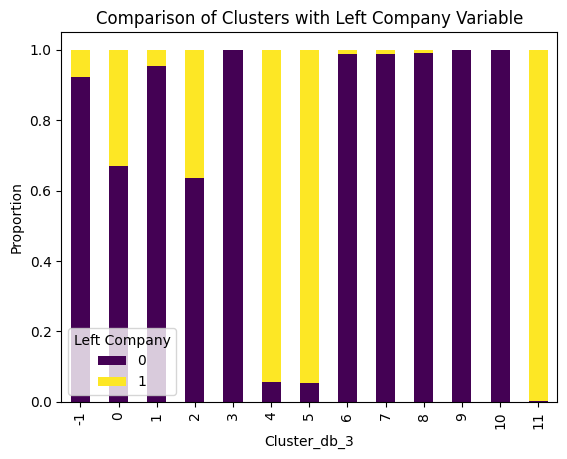

In [87]:
comparison_df = data[['Cluster_db_3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### k-distance graph

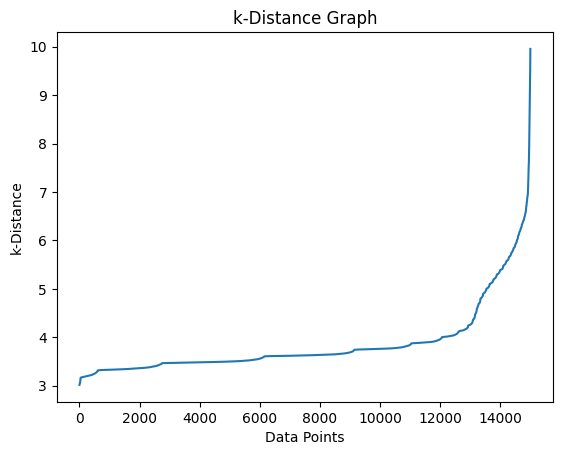

In [88]:
# estimating eps value 
k = 19  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [89]:

eps = 3.75  
min_samples = 20

#Run DBSCAN and evaluate
db_4 = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
core_samples_mask = np.zeros_like(db_4.labels_, dtype=bool)
core_samples_mask[db_4.core_sample_indices_] = True
labels = db_4.labels_
data['Cluster_db_4'] = db_4.fit_predict(X)
X_cluster['Cluster_db_4']=data['Cluster_db_4']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_4.fit_predict(X)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

Silhouette Score: 0.2410291712468422


In [90]:
X_cluster.groupby('Cluster_db_4').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_db_4                                                     
-1                 0.495985          3.138876         0.522858   
 0                 0.481234          5.000000         0.251160   
 1                 0.517967          4.979842         0.264173   
 2                 0.490531          5.000000         0.249924   
 3                 0.507402          4.717362         0.398154   
 4                 0.528000          5.000000         0.264000   
 5                 0.521092          1.000000         0.463283   
 6                 0.505263          1.000000         0.465872   
 7                 0.483193          1.000000         0.463629   
 8                 0.642857          1.000000         0.459821   
 9                 0.489268          4.000000         0.766976   
 10                0.509699          4.000000         0.768713   
 11                0.489531          4.000000         0.843703   
 12                0.497006          4.071856         0.798957   

              number_project  average_montly_hours  time_spend_company  \
Cluster_db_4                                                             
-1                  0.414832              0.502958            2.105338   
 0                  0.187823              0.429642            0.050042   
 1                  0.420684              0.326587            0.110429   
 2                  0.174465              0.409933            0.086133   
 3                  0.213459              0.386945            0.325707   
 4                  0.353600              0.664374           -0.624000   
 5                  0.371216              0.332773           -0.171216   
 6                  0.274737              0.528947           -0.221053   
 7                  0.256303              0.487042           -0.252101   
 8                  0.200000              0.439252           -0.428571   
 9                  0.364899              0.496268           -0.039141   
 10                 0.359067              0.490701            0.024740   
 11                 0.667797              0.763769            1.605184   
 12                 0.661677              0.768650            1.721557   

              work_accident  promotion_last_5years    gender  linkedin_hits  \
Cluster_db_4                                                                  
-1                 0.196504               0.101559  0.507322       0.329018   
 0                 0.130942               0.003336  0.515430       0.491243   
 1                 0.173532               0.000876  0.505697       0.484443   
 2                 0.113622               0.000000  0.501527       0.500515   
 3                 0.055182               0.000000  0.524899       0.390814   
 4                 0.112000               0.000000  0.464000       0.496875   
 5                 0.141439               0.000000  0.496278       0.486740   
 6                 0.173684               0.000000  0.485965       0.510965   
 7                 0.117647               0.004202  0.542017       0.463038   
 8                 0.000000               0.000000  0.714286       0.559152   
 9                 0.172980               0.025253  0.502525       0.070105   
 10                0.173461               0.016306  0.502671       0.070811   
 11                0.048853               0.000000  0.503490       0.071816   
 12                0.049401               0.000000  0.528443       0.094943   

              ...  Cluster_kmeans_2  Cluster_kmeans_6  Cluster_ac2  \
Cluster_db_4  ...                                                    
-1            ...          0.652338          2.139348     0.210203   
 0            ...          0.095079          4.532110     0.000000   
 1            ...          0.035057          0.003506     0.000000   
 2            ...          0.089798          4.592547     0.000000   
 3            ...          0.290713          2.265141     0.000000   
 4            ...

In [91]:
cluster_distribution = data['Cluster_db_4'].value_counts().sort_index()
cluster_distribution

Cluster_db_4
-1     2117
 0     1199
 1     1141
 2     1637
 3      743
 4      125
 5      403
 6      570
 7      238
 8       14
 9     1584
 10    3557
 11    1003
 12     668
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_4                    
-1            0.930090  0.069910
 0            0.668891  0.331109
 1            0.955302  0.044698
 2            0.633476  0.366524
 3            0.022880  0.977120
 4            1.000000  0.000000
 5            0.990074  0.009926
 6            0.991228  0.008772
 7            0.991597  0.008403
 8            0.928571  0.071429
 9            1.000000  0.000000
 10           0.999438  0.000562
 11           0.000997  0.999003
 12           0.052395  0.947605


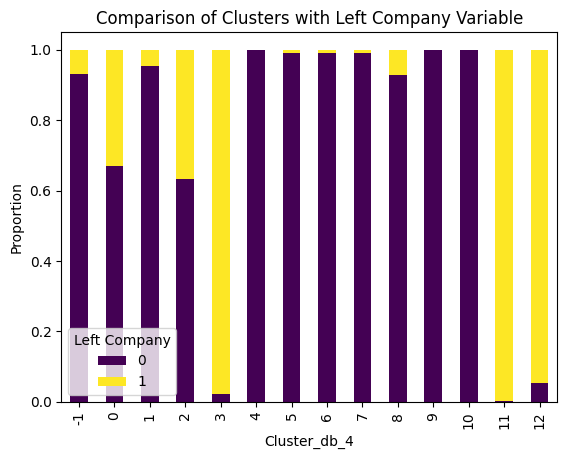

In [92]:
comparison_df = data[['Cluster_db_4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### k-distance graph

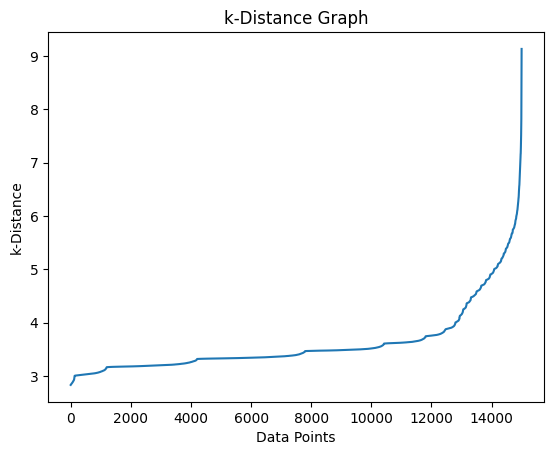

In [93]:
# estimating eps value 
k = 9  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [94]:

eps = 3.75  
min_samples = 6

#Run DBSCAN and evaluate
db_5 = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
core_samples_mask = np.zeros_like(db_5.labels_, dtype=bool)
core_samples_mask[db_5.core_sample_indices_] = True
labels = db_5.labels_
data['Cluster_db_5'] = db_5.fit_predict(X) 
X_cluster['Cluster_db_5']=data['Cluster_db_5']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_5.fit_predict(X)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

Silhouette Score: 0.2709710251743079


In [95]:
X_cluster.groupby('Cluster_db_5').mean()

will_relocate  emp_sat_onprem_5  last_evaluation  \
Cluster_db_5                                                     
-1                 0.502176          3.201850         0.517096   
 0                 0.480992          5.000000         0.250865   
 1                 0.516129          4.979948         0.264372   
 2                 0.490531          5.000000         0.249924   
 3                 0.528000          5.000000         0.264000   
 4                 0.497006          4.071856         0.798957   
 5                 0.507402          4.717362         0.398154   
 6                 0.071429          5.000000         0.254464   
 7                 0.166667          5.000000         0.309896   
 8                 0.492063          1.000000         0.463418   
 9                 0.505263          1.000000         0.465872   
 10                0.521092          1.000000         0.463283   
 11                0.250000          1.000000         0.452344   
 12                0.474576          1.000000         0.471928   
 13                0.166667          1.000000         0.442708   
 14                0.166667          1.000000         0.447917   
 15                0.428571          1.000000         0.441964   
 16                0.400000          1.000000         0.463542   
 17                0.333333          1.000000         0.473958   
 18                0.166667          1.000000         0.466146   
 19                1.000000          1.000000         0.494792   
 20                0.489268          4.000000         0.766976   
 21                0.509699          4.000000         0.768713   
 22                0.489531          4.000000         0.843703   
 23                0.166667          4.000000         0.580729   
 24                0.708333          4.000000         0.795573   
 25                0.800000          4.000000         0.792188   
 26                0.600000          4.000000         0.735938   
 27                0.200000          4.000000         0.771875   
 28                0.777778          4.000000         0.766493   
 29                0.166667          4.000000         0.716146   
 30                0.666667          4.000000         0.867188   
 31                0.857143          4.000000         0.747768   
 32                0.500000          4.000000         0.841146   
 33                0.166667          4.000000         0.796875   
 34                0.571429          4.000000         0.837054   

              number_project  average_montly_hours  time_spend_company  \
Cluster_db_5                                                             
-1                  0.410555              0.506414            2.288901   
 0                  0.188430              0.431281            0.079339   
 1                  0.420924              0.326117            0.125545   
 2                  0.174465              0.409933            0.086133   
 3                  0.353600              0.664374           -0.624000   
 4                  0.661677              0.768650            1.721557   
 5                  0.213459              0.386945            0.325707   
 6                  0.285714              0.591121           -0.714286   
 7                  0.800000              0.431464            1.000000   
 8                  0.253175              0.484387           -0.261905   
 9                  0.274737              0.528947           -0.221053   
 10                 0.371216              0.332773           -0.171216   
 11                 0.300000              0.564720           -0.250000   
 12                 0.613559              0.401236           -0.033898   
 13                 0.433333              0.411994           -0.166667   
 14                 0.166667              0.453271            0.333333   
 15                 0.257143              0.534713            0.285714   
 16                 0.373333              0.322430           -0.200000   
 17                 0.600

In [96]:
cluster_distribution = data['Cluster_db_5'].value_counts().sort_index()
cluster_distribution

Cluster_db_5
-1     1838
 0     1210
 1     1147
 2     1637
 3      125
 4      668
 5      743
 6       14
 7        6
 8      252
 9      570
 10     403
 11      20
 12      59
 13       6
 14       6
 15       7
 16      15
 17       6
 18       6
 19       6
 20    1584
 21    3557
 22    1003
 23       6
 24      24
 25      10
 26      10
 27       5
 28      18
 29       6
 30       6
 31       7
 32       6
 33       6
 34       7
Name: count, dtype: int64

Comparison Table:
 left_company         0         1
Cluster_db_5                    
-1            0.923286  0.076714
 0            0.671901  0.328099
 1            0.954664  0.045336
 2            0.633476  0.366524
 3            1.000000  0.000000
 4            0.052395  0.947605
 5            0.022880  0.977120
 6            1.000000  0.000000
 7            0.500000  0.500000
 8            0.988095  0.011905
 9            0.991228  0.008772
 10           0.990074  0.009926
 11           1.000000  0.000000
 12           0.949153  0.050847
 13           1.000000  0.000000
 14           1.000000  0.000000
 15           1.000000  0.000000
 16           1.000000  0.000000
 17           1.000000  0.000000
 18           1.000000  0.000000
 19           1.000000  0.000000
 20           1.000000  0.000000
 21           0.999438  0.000562
 22           0.000997  0.999003
 23           1.000000  0.000000
 24           1.000000  0.000000
 25           1.000000  0.000000
 26           1.000000  

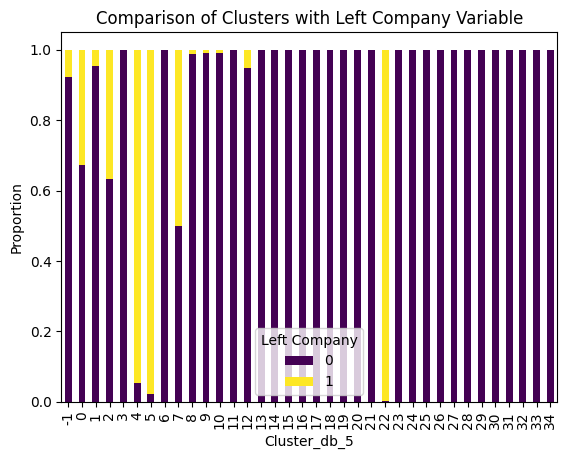

In [97]:
comparison_df = data[['Cluster_db_5', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_5'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_5')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

## Gaussian mixtures clustering

### Determining the optimal number of clusters

Text(0.5, 0, 'Number Of Component')

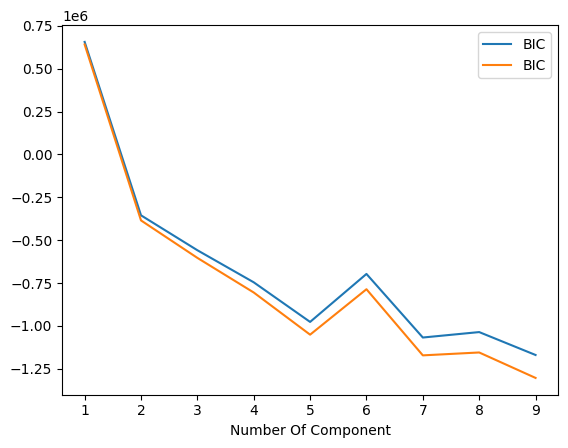

In [98]:
#Prepare
n_conponent = np.arange(1,10)

#Create GGM Model
models = [GaussianMixture(n_components = n,
                          random_state=42).fit(X) for n in n_conponent]
#Plot
plt.plot(n_conponent,
         [m.bic(X) for m in models],
         label = 'BIC')
plt.plot(n_conponent,
         [m.aic(X) for m in models],
         label = 'BIC')
plt.legend()
plt.xlabel("Number Of Component")

In [99]:
# create GM Models
model_gauss = GaussianMixture(n_components=8,
                        random_state=42).fit(X)
cluster_Gaussian_1 = pd.Series(model_gauss.predict(X))
X['cluster_Gaussian_1'] = cluster_Gaussian_1
X

will_relocate  emp_sat_onprem_5  last_evaluation  number_project  \
0                  0               5.0              0.0             0.2   
1                  0               5.0              0.0             0.6   
2                  0               5.0              0.0             0.0   
3                  0               5.0              0.0             0.4   
4                  0               5.0              0.0             0.8   
...              ...               ...              ...             ...   
14994              1               4.0              1.0             0.4   
14995              1               4.0              1.0             0.4   
14996              0               4.0              1.0             0.6   
14997              0               4.0              1.0             0.6   
14998              1               4.0              1.0             0.0   

       average_montly_hours  time_spend_company  work_accident  \
0                  0.336449                 0.0              1   
1                  0.294393                -1.0              0   
2                  0.869159                 0.0              0   
3                  0.850467                 1.0              1   
4                  0.747664                 2.0              0   
...                     ...                 ...            ...   
14994              0.728972                 2.0              0   
14995              0.635514                 2.0              0   
14996              0.682243                 2.0              0   
14997              0.593458                 3.0              0   
14998              0.275701                 2.0              0   

       promotion_last_5years  gender  linkedin_hits  ...  Cluster_ac3  \
0                          0       0       0.062500  ...            2   
1                          0       1       0.890625  ...            1   
2                          0       1       0.640625  ...            2   
3                          0       0       0.562500  ...            2   
4                          0       1       0.078125  ...            2   
...                      ...     ...            ...  ...          ...   
14994                      0       1       0.000000  ...            1   
14995                      0       1       0.078125  ...            0   
14996                      0       1       0.046875  ...            0   
14997                      0       0       0.015625  ...            0   
14998                      0       1       0.078125  ...            0   

       Cluster_ac4  Cluster_ac5  Cluster_ac6  Cluster_db_1  Cluster_db_2  \
0                2            0            5             0             0   
1                0            2            2             1             1   
2                2            0            1             2             2   
3                2            0            1             2             2   
4                2            0            5             0             0   
...            ...          ...          ...           ...           ...   
14994            0            2            2             1             1   
14995            3            3            3            12            18   
14996            3            3            3            12            18   
14997            3            3            3            12            18   
14998            3            3            3            -1            -1   

       Cluster_db_3  Cluster_db_4  Cluster_db_5  cluster_Gaussian_1  
0                 0             0             0                   4  
1                 1             1             1                   4  
2                 2             2             2                   2  
3                 2             2             2                   2  
4                 0             0             0                   4  
...             ...           ...           ...                 ...  
14994             4             3

In [100]:
X.cluster_Gaussian_1.value_counts()


cluster_Gaussian_1
1    3557
4    3098
2    2525
7    1653
0    1397
6    1098
3    1003
5     668
Name: count, dtype: int64

In [101]:
pd.DataFrame(model_gauss.means_,
             columns = list(X.iloc[:, :-1].columns))

will_relocate  emp_sat_onprem_5  last_evaluation  number_project  \
0       0.505369          1.090193         0.474163        0.321546   
1       0.509699          4.000000         0.768713        0.359067   
2       0.494257          4.916832         0.294406        0.196911   
3       0.489531          4.000000         0.843703        0.667797   
4       0.498618          4.743744         0.344534        0.315503   
5       0.497006          4.071856         0.798957        0.661677   
6       0.502999          2.682994         0.446757        0.444940   
7       0.490018          4.000000         0.767052        0.367695   

   average_montly_hours  time_spend_company  work_accident  \
0              0.456211           -0.186829       0.151754   
1              0.490701            0.024740       0.173461   
2              0.416821            0.119208       0.097030   
3              0.763769            1.605184       0.048853   
4              0.413947            0.715702       0.160700   
5              0.768650            1.721557       0.049401   
6              0.496532            2.035124       0.209740   
7              0.496520            0.082880       0.172414   

   promotion_last_5years    gender  linkedin_hits  ...  Cluster_ac2  \
0               0.000000  0.496063       0.479610  ...     0.000000   
1               0.016306  0.502671       0.070811  ...     1.000000   
2               0.000000  0.508515       0.468038  ...     0.000000   
3               0.000000  0.503490       0.071816  ...     1.000000   
4               0.069980  0.501584       0.410548  ...     0.114331   
5               0.000000  0.528443       0.094943  ...     0.000000   
6               0.003653  0.529300       0.443518  ...     0.065265   
7               0.024198  0.506957       0.070185  ...     0.011494   

   Cluster_ac3  Cluster_ac4  Cluster_ac5  Cluster_ac6  Cluster_db_1  \
0     1.634932     1.269864     0.730136     2.195419      5.478168   
1     0.000000     1.000000     1.000000     0.000000     11.000000   
2     1.648317     1.296634     0.703366     1.351683      1.753663   
3     0.000000     3.000000     3.000000     3.000000     12.000000   
4     1.291123     1.042321     1.235055     3.176867      0.131934   
5     2.000000     2.000000     0.000000     1.000000      4.000000   
6     1.478727     1.228989     0.957191     2.283685      1.270089   
7     0.988506     0.034483     3.928010     3.928010      9.625529   

   Cluster_db_2  Cluster_db_3  Cluster_db_4  Cluster_db_5  
0      7.098783      6.523264      5.034359     10.026485  
1     16.000000     10.000000     10.000000     21.000000  
2      1.767921      2.636436      2.369505      2.966337  
3     18.000000     11.000000     11.000000     22.000000  
4      0.132256      0.129354      0.125161      0.132901  
5      4.000000      5.000000     12.000000      4.000000  
6      3.454342      0.338677     -1.000000     -1.000000  
7     15.289171      8.582577      8.582577     20.364186  

[8 rows x 61 columns]

Comparison Table:
 left_company               0         1
cluster_Gaussian_1                    
0                   0.989263  0.010737
1                   0.999438  0.000562
2                   0.473663  0.526337
3                   0.000997  0.999003
4                   0.837637  0.162363
5                   0.052395  0.947605
6                   0.920765  0.079235
7                   1.000000  0.000000


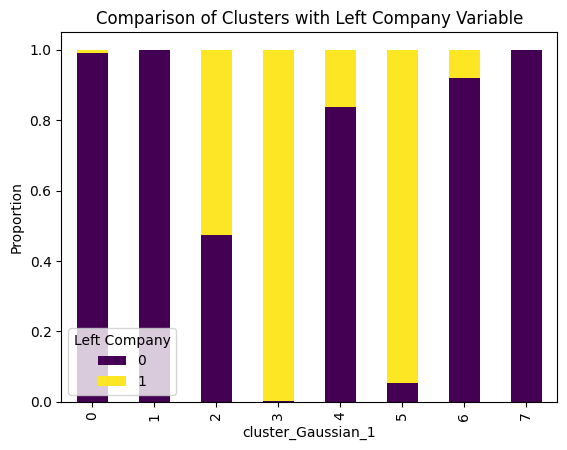

In [102]:
data['cluster_Gaussian_1'] = cluster_Gaussian_1
comparison_df = data[['cluster_Gaussian_1', 'left_company']]
comparison_table = pd.crosstab(comparison_df['cluster_Gaussian_1'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('cluster_Gaussian_1')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()